In [91]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from PIL import Image
import rasterio
from rasterio.windows import Window
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.keras.models import Sequential
from matplotlib.pyplot import figure
from tensorflow.keras.models import save_model
import cv2
import glob
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [71]:
# sns.set_theme(style="whitegrid")
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
<Figure size 640x480 with 0 Axes>
<Figure size 640x480 with 0 Axes>
# sns.set_theme(style="whitegrid")
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
​
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [133]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [134]:
train_data_dir = './eurosat'

In [135]:
data = {}
img_height, img_width = 0, 0

In [136]:
for path, dirs, files in os.walk(train_data_dir):
    print(path)
    print(dirs)
    print(files)
    dir_name = path.split('/')[-1]
    first_file = files[0]
    file_name, file_ext = first_file.split('.')
    if file_ext == 'jpg':
        image = Image.open(f'{path}/{first_file}')
        img_width, img_height = image.size
        data[dir_name] = {'count': len(files), 'height': img_height, 'width': img_width}

./eurosat
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'rgb', 'River', 'SeaLake']
['label_map.json', 'test.csv', 'train.csv', 'validation.csv']
./eurosat\AnnualCrop
[]
['AnnualCrop_1.jpg', 'AnnualCrop_10.jpg', 'AnnualCrop_100.jpg', 'AnnualCrop_1000.jpg', 'AnnualCrop_1001.jpg', 'AnnualCrop_1002.jpg', 'AnnualCrop_1003.jpg', 'AnnualCrop_1004.jpg', 'AnnualCrop_1005.jpg', 'AnnualCrop_1006.jpg', 'AnnualCrop_1007.jpg', 'AnnualCrop_1008.jpg', 'AnnualCrop_1009.jpg', 'AnnualCrop_101.jpg', 'AnnualCrop_1010.jpg', 'AnnualCrop_1011.jpg', 'AnnualCrop_1012.jpg', 'AnnualCrop_1013.jpg', 'AnnualCrop_1014.jpg', 'AnnualCrop_1015.jpg', 'AnnualCrop_1016.jpg', 'AnnualCrop_1017.jpg', 'AnnualCrop_1018.jpg', 'AnnualCrop_1019.jpg', 'AnnualCrop_102.jpg', 'AnnualCrop_1020.jpg', 'AnnualCrop_1021.jpg', 'AnnualCrop_1022.jpg', 'AnnualCrop_1023.jpg', 'AnnualCrop_1024.jpg', 'AnnualCrop_1025.jpg', 'AnnualCrop_1026.jpg', 'AnnualCrop_1027.jpg', 'AnnualC

IndexError: list index out of range

In [137]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.head(10))

                              count  height  width
eurosat\AnnualCrop             3000      64     64
eurosat\Forest                 3000      64     64
eurosat\HerbaceousVegetation   3000      64     64
eurosat\Highway                2500      64     64
eurosat\Industrial             2500      64     64
eurosat\Pasture                2000      64     64
eurosat\PermanentCrop          2500      64     64
eurosat\Residential            3000      64     64


In [138]:
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 27000 files belonging to 11 classes.
Using 21600 files for training.
Found 27000 files belonging to 11 classes.
Using 5400 files for validation.


In [139]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'number of classes: {num_classes}', class_names)

# retrieve a single batch of 32 images.
image_batch, label_batch = next(iter(train_dataset))

# image_batch = tensor of the shape (32, 64, 64, 3), image shape = 64 x 64 x 3 (height x width x channels)
# label_batch = tensor of the shape (32,), (integer labels)
print(image_batch.shape)
print(label_batch.shape)

# check image value range
first_image = image_batch[0].numpy().astype("uint8")
print(np.min(first_image), np.max(first_image))

number of classes: 11 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'rgb']
(32, 64, 64, 3)
(32,)
32 121


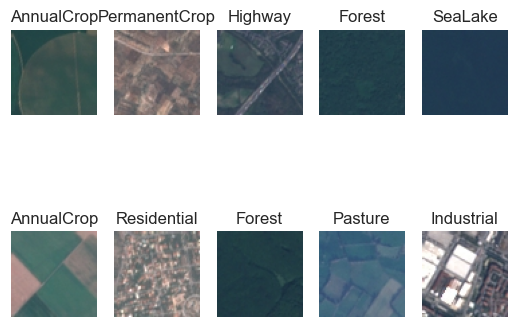

In [140]:
plt.figure()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
rescaling_layer = layers.experimental.preprocessing.Rescaling(
    scale=1. / 255,
    input_shape=(img_height, img_width, 3)
)

In [20]:
rescaled_ds = train_dataset.map(lambda x, y: (rescaling_layer(x), y))
image_batch, labels_batch = next(iter(rescaled_ds))
first_image = image_batch[0].numpy().astype("float32")


In [21]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [22]:
model = Sequential([
    # layer 1 - preprocessing layer with convolution and max pooling
    Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 4 - convolutional layer and max pooling
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    Dropout(rate=0.1),
    Flatten(),

    # layer 5 - dense fully connected layer
    Dense(units=128, activation='relu'),

    # layer 6 - output dense layer
    Dense(num_classes)
])



In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs = 30
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/30
675/675 [==============================] - 63s 91ms/step - loss: 1.3691 - accuracy: 0.5791 - val_loss: 0.8593 - val_accuracy: 0.6948
Epoch 2/30
675/675 [==============================] - 68s 101ms/step - loss: 0.8033 - accuracy: 0.7190 - val_loss: 0.7135 - val_accuracy: 0.7352
Epoch 3/30
675/675 [==============================] - 66s 98ms/step - loss: 0.6706 - accuracy: 0.7663 - val_loss: 0.6315 - val_accuracy: 0.7676
Epoch 4/30
675/675 [==============================] - 61s 90ms/step - loss: 0.5952 - accuracy: 0.7901 - val_loss: 0.5767 - val_accuracy: 0.7937
Epoch 5/30
675/675 [==============================] - 60s 88ms/step - loss: 0.5294 - accuracy: 0.8122 - val_loss: 0.6544 - val_accuracy: 0.7694
Epoch 6/30
675/675 [==============================] - 66s 97ms/step - loss: 0.4819 - accuracy: 0.8293 - val_loss: 0.5418 - val_accuracy: 0.8170
Epoch 7/30
675/675 [==============================] - 66s 97ms/step - loss: 0.4359 - accuracy: 0.8460 - val_loss: 0.5559 - val_accuracy

In [56]:
tf.saved_model.save(model, "my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [57]:
loaded_model = tf.saved_model.load("my_model")

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

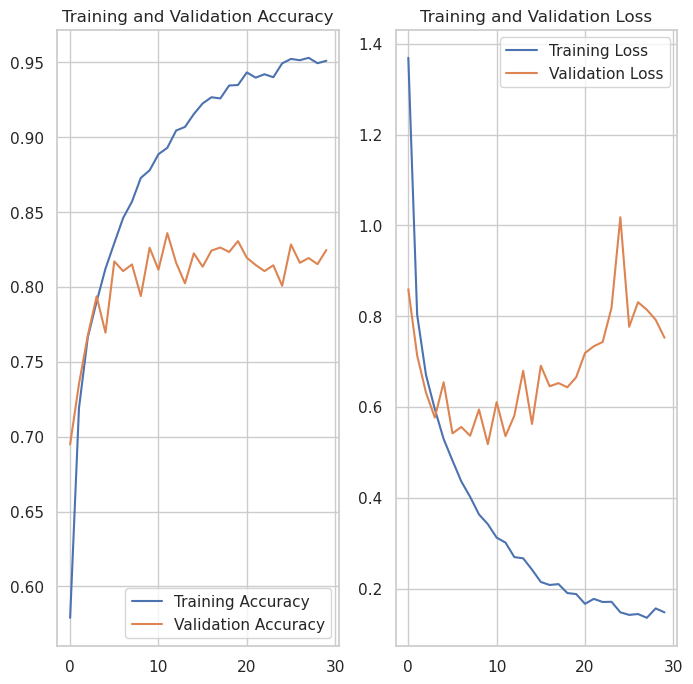

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
image_folder = './mydata/imagess'

In [32]:
image_files = os.listdir(image_folder)

In [33]:
num_tiles = len(image_files)

In [34]:
print(num_tiles)

12100


In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 64, 64, 8)         224       
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 32, 32, 8)         0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 32, 32, 16)        1168      
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 16, 16, 16)        0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 16, 16, 32)        4640      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 8, 8, 32)          0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 8, 8, 64)         

# Make predictions for each image

In [36]:
#Make predictions for each image
for image_file in image_files:
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    # Preprocess the image (if needed)
    # Perform any necessary preprocessing steps such as resizing, normalization, etc.

    # Make prediction
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class_label = class_names[predicted_class_index]

    # Print the prediction result
    print(f"Image: {image_file}, Predicted class: {predicted_class_label}")

Image: ._data_00001.tif, Predicted class: Industrial
Image: ._data_00002.tif, Predicted class: Industrial
Image: ._data_00003.tif, Predicted class: Highway
Image: ._data_00004.tif, Predicted class: Residential
Image: ._data_00005.tif, Predicted class: Highway
Image: ._data_00006.tif, Predicted class: Pasture
Image: ._data_00007.tif, Predicted class: PermanentCrop
Image: ._data_00008.tif, Predicted class: HerbaceousVegetation
Image: ._data_00009.tif, Predicted class: Residential
Image: ._data_00010.tif, Predicted class: Residential
Image: ._data_00011.tif, Predicted class: Residential
Image: ._data_00012.tif, Predicted class: Industrial
Image: ._data_00013.tif, Predicted class: Industrial
Image: ._data_00014.tif, Predicted class: Residential
Image: ._data_00015.tif, Predicted class: Residential
Image: ._data_00016.tif, Predicted class: Industrial
Image: ._data_00017.tif, Predicted class: Highway
Image: ._data_00018.tif, Predicted class: PermanentCrop
Image: ._data_00019.tif, Predicted c

Image: ._data_00156.tif, Predicted class: PermanentCrop
Image: ._data_00157.tif, Predicted class: Highway
Image: ._data_00158.tif, Predicted class: Highway
Image: ._data_00159.tif, Predicted class: Highway
Image: ._data_00160.tif, Predicted class: Residential
Image: ._data_00161.tif, Predicted class: Residential
Image: ._data_00162.tif, Predicted class: Pasture
Image: ._data_00163.tif, Predicted class: PermanentCrop
Image: ._data_00164.tif, Predicted class: PermanentCrop
Image: ._data_00165.tif, Predicted class: Residential
Image: ._data_00166.tif, Predicted class: Highway
Image: ._data_00167.tif, Predicted class: Industrial
Image: ._data_00168.tif, Predicted class: Residential
Image: ._data_00169.tif, Predicted class: River
Image: ._data_00170.tif, Predicted class: HerbaceousVegetation
Image: ._data_00171.tif, Predicted class: Highway
Image: ._data_00172.tif, Predicted class: Residential
Image: ._data_00173.tif, Predicted class: Residential
Image: ._data_00174.tif, Predicted class: Ri

Image: ._data_00310.tif, Predicted class: Residential
Image: ._data_00311.tif, Predicted class: Residential
Image: ._data_00312.tif, Predicted class: Residential
Image: ._data_00313.tif, Predicted class: Residential
Image: ._data_00314.tif, Predicted class: Residential
Image: ._data_00315.tif, Predicted class: Residential
Image: ._data_00316.tif, Predicted class: Industrial
Image: ._data_00317.tif, Predicted class: Residential
Image: ._data_00318.tif, Predicted class: Residential
Image: ._data_00319.tif, Predicted class: Residential
Image: ._data_00320.tif, Predicted class: Residential
Image: ._data_00321.tif, Predicted class: Residential
Image: ._data_00322.tif, Predicted class: Residential
Image: ._data_00323.tif, Predicted class: Residential
Image: ._data_00324.tif, Predicted class: Residential
Image: ._data_00325.tif, Predicted class: Residential
Image: ._data_00326.tif, Predicted class: Residential
Image: ._data_00327.tif, Predicted class: Residential
Image: ._data_00328.tif, Pred

Image: ._data_00464.tif, Predicted class: Residential
Image: ._data_00465.tif, Predicted class: Residential
Image: ._data_00466.tif, Predicted class: Residential
Image: ._data_00467.tif, Predicted class: Residential
Image: ._data_00468.tif, Predicted class: Residential
Image: ._data_00469.tif, Predicted class: Residential
Image: ._data_00470.tif, Predicted class: Residential
Image: ._data_00471.tif, Predicted class: Residential
Image: ._data_00472.tif, Predicted class: Residential
Image: ._data_00473.tif, Predicted class: Industrial
Image: ._data_00474.tif, Predicted class: Residential
Image: ._data_00475.tif, Predicted class: Industrial
Image: ._data_00476.tif, Predicted class: Industrial
Image: ._data_00477.tif, Predicted class: Residential
Image: ._data_00478.tif, Predicted class: Residential
Image: ._data_00479.tif, Predicted class: Highway
Image: ._data_00480.tif, Predicted class: Residential
Image: ._data_00481.tif, Predicted class: Residential
Image: ._data_00482.tif, Predicted 

Image: ._data_00616.tif, Predicted class: HerbaceousVegetation
Image: ._data_00617.tif, Predicted class: HerbaceousVegetation
Image: ._data_00618.tif, Predicted class: Industrial
Image: ._data_00619.tif, Predicted class: Highway
Image: ._data_00620.tif, Predicted class: Residential
Image: ._data_00621.tif, Predicted class: Residential
Image: ._data_00622.tif, Predicted class: Residential
Image: ._data_00623.tif, Predicted class: Industrial
Image: ._data_00624.tif, Predicted class: Residential
Image: ._data_00625.tif, Predicted class: Highway
Image: ._data_00626.tif, Predicted class: Residential
Image: ._data_00627.tif, Predicted class: Residential
Image: ._data_00628.tif, Predicted class: Residential
Image: ._data_00629.tif, Predicted class: PermanentCrop
Image: ._data_00630.tif, Predicted class: PermanentCrop
Image: ._data_00631.tif, Predicted class: Industrial
Image: ._data_00632.tif, Predicted class: Residential
Image: ._data_00633.tif, Predicted class: Residential
Image: ._data_006

Image: ._data_00768.tif, Predicted class: Industrial
Image: ._data_00769.tif, Predicted class: Industrial
Image: ._data_00770.tif, Predicted class: Forest
Image: ._data_00771.tif, Predicted class: Industrial
Image: ._data_00772.tif, Predicted class: Residential
Image: ._data_00773.tif, Predicted class: Industrial
Image: ._data_00774.tif, Predicted class: Residential
Image: ._data_00775.tif, Predicted class: Industrial
Image: ._data_00776.tif, Predicted class: Residential
Image: ._data_00777.tif, Predicted class: Residential
Image: ._data_00778.tif, Predicted class: Residential
Image: ._data_00779.tif, Predicted class: Industrial
Image: ._data_00780.tif, Predicted class: Residential
Image: ._data_00781.tif, Predicted class: Residential
Image: ._data_00782.tif, Predicted class: PermanentCrop
Image: ._data_00783.tif, Predicted class: Highway
Image: ._data_00784.tif, Predicted class: PermanentCrop
Image: ._data_00785.tif, Predicted class: Industrial
Image: ._data_00786.tif, Predicted class

Image: ._data_00921.tif, Predicted class: Highway
Image: ._data_00922.tif, Predicted class: Pasture
Image: ._data_00923.tif, Predicted class: Highway
Image: ._data_00924.tif, Predicted class: HerbaceousVegetation
Image: ._data_00925.tif, Predicted class: AnnualCrop
Image: ._data_00926.tif, Predicted class: PermanentCrop
Image: ._data_00927.tif, Predicted class: Residential
Image: ._data_00928.tif, Predicted class: HerbaceousVegetation
Image: ._data_00929.tif, Predicted class: PermanentCrop
Image: ._data_00930.tif, Predicted class: HerbaceousVegetation
Image: ._data_00931.tif, Predicted class: Pasture
Image: ._data_00932.tif, Predicted class: Industrial
Image: ._data_00933.tif, Predicted class: Industrial
Image: ._data_00934.tif, Predicted class: Industrial
Image: ._data_00935.tif, Predicted class: Industrial
Image: ._data_00936.tif, Predicted class: Residential
Image: ._data_00937.tif, Predicted class: Industrial
Image: ._data_00938.tif, Predicted class: Residential
Image: ._data_00939

Image: ._data_01075.tif, Predicted class: Highway
Image: ._data_01076.tif, Predicted class: Highway
Image: ._data_01077.tif, Predicted class: Residential
Image: ._data_01078.tif, Predicted class: Residential
Image: ._data_01079.tif, Predicted class: Residential
Image: ._data_01080.tif, Predicted class: Residential
Image: ._data_01081.tif, Predicted class: Industrial
Image: ._data_01082.tif, Predicted class: Industrial
Image: ._data_01083.tif, Predicted class: Residential
Image: ._data_01084.tif, Predicted class: Highway
Image: ._data_01085.tif, Predicted class: Residential
Image: ._data_01086.tif, Predicted class: Residential
Image: ._data_01087.tif, Predicted class: Highway
Image: ._data_01088.tif, Predicted class: Residential
Image: ._data_01089.tif, Predicted class: Residential
Image: ._data_01090.tif, Predicted class: HerbaceousVegetation
Image: ._data_01091.tif, Predicted class: PermanentCrop
Image: ._data_01092.tif, Predicted class: Residential
Image: ._data_01093.tif, Predicted 

Image: ._data_01229.tif, Predicted class: Industrial
Image: ._data_01230.tif, Predicted class: Industrial
Image: ._data_01231.tif, Predicted class: Residential
Image: ._data_01232.tif, Predicted class: Industrial
Image: ._data_01233.tif, Predicted class: Residential
Image: ._data_01234.tif, Predicted class: Residential
Image: ._data_01235.tif, Predicted class: Industrial
Image: ._data_01236.tif, Predicted class: Residential
Image: ._data_01237.tif, Predicted class: Industrial
Image: ._data_01238.tif, Predicted class: Industrial
Image: ._data_01239.tif, Predicted class: Industrial
Image: ._data_01240.tif, Predicted class: Highway
Image: ._data_01241.tif, Predicted class: Industrial
Image: ._data_01242.tif, Predicted class: Industrial
Image: ._data_01243.tif, Predicted class: Industrial
Image: ._data_01244.tif, Predicted class: Industrial
Image: ._data_01245.tif, Predicted class: Highway
Image: ._data_01246.tif, Predicted class: Residential
Image: ._data_01247.tif, Predicted class: Highw

Image: ._data_01384.tif, Predicted class: Industrial
Image: ._data_01385.tif, Predicted class: Residential
Image: ._data_01386.tif, Predicted class: Residential
Image: ._data_01387.tif, Predicted class: Residential
Image: ._data_01388.tif, Predicted class: Highway
Image: ._data_01389.tif, Predicted class: Pasture
Image: ._data_01390.tif, Predicted class: HerbaceousVegetation
Image: ._data_01391.tif, Predicted class: PermanentCrop
Image: ._data_01392.tif, Predicted class: PermanentCrop
Image: ._data_01393.tif, Predicted class: Highway
Image: ._data_01394.tif, Predicted class: Residential
Image: ._data_01395.tif, Predicted class: PermanentCrop
Image: ._data_01396.tif, Predicted class: Industrial
Image: ._data_01397.tif, Predicted class: Highway
Image: ._data_01398.tif, Predicted class: Residential
Image: ._data_01399.tif, Predicted class: Industrial
Image: ._data_01400.tif, Predicted class: Residential
Image: ._data_01401.tif, Predicted class: Residential
Image: ._data_01402.tif, Predict

Image: ._data_01538.tif, Predicted class: Highway
Image: ._data_01539.tif, Predicted class: Residential
Image: ._data_01540.tif, Predicted class: HerbaceousVegetation
Image: ._data_01541.tif, Predicted class: Industrial
Image: ._data_01542.tif, Predicted class: Industrial
Image: ._data_01543.tif, Predicted class: Residential
Image: ._data_01544.tif, Predicted class: Highway
Image: ._data_01545.tif, Predicted class: Residential
Image: ._data_01546.tif, Predicted class: Highway
Image: ._data_01547.tif, Predicted class: Highway
Image: ._data_01548.tif, Predicted class: Residential
Image: ._data_01549.tif, Predicted class: Highway
Image: ._data_01550.tif, Predicted class: Industrial
Image: ._data_01551.tif, Predicted class: Residential
Image: ._data_01552.tif, Predicted class: Residential
Image: ._data_01553.tif, Predicted class: HerbaceousVegetation
Image: ._data_01554.tif, Predicted class: Residential
Image: ._data_01555.tif, Predicted class: Industrial
Image: ._data_01556.tif, Predicted

Image: ._data_01692.tif, Predicted class: Residential
Image: ._data_01693.tif, Predicted class: Highway
Image: ._data_01694.tif, Predicted class: Residential
Image: ._data_01695.tif, Predicted class: Highway
Image: ._data_01696.tif, Predicted class: Residential
Image: ._data_01697.tif, Predicted class: Industrial
Image: ._data_01698.tif, Predicted class: Residential
Image: ._data_01699.tif, Predicted class: Industrial
Image: ._data_01700.tif, Predicted class: Industrial
Image: ._data_01701.tif, Predicted class: Residential
Image: ._data_01702.tif, Predicted class: Industrial
Image: ._data_01703.tif, Predicted class: Residential
Image: ._data_01704.tif, Predicted class: Highway
Image: ._data_01705.tif, Predicted class: Pasture
Image: ._data_01706.tif, Predicted class: Residential
Image: ._data_01707.tif, Predicted class: Residential
Image: ._data_01708.tif, Predicted class: Residential
Image: ._data_01709.tif, Predicted class: Highway
Image: ._data_01710.tif, Predicted class: Residentia

Image: ._data_01847.tif, Predicted class: Residential
Image: ._data_01848.tif, Predicted class: Industrial
Image: ._data_01849.tif, Predicted class: Highway
Image: ._data_01850.tif, Predicted class: Highway
Image: ._data_01851.tif, Predicted class: Residential
Image: ._data_01852.tif, Predicted class: Industrial
Image: ._data_01853.tif, Predicted class: Residential
Image: ._data_01854.tif, Predicted class: Residential
Image: ._data_01855.tif, Predicted class: Residential
Image: ._data_01856.tif, Predicted class: Residential
Image: ._data_01857.tif, Predicted class: Highway
Image: ._data_01858.tif, Predicted class: Residential
Image: ._data_01859.tif, Predicted class: Industrial
Image: ._data_01860.tif, Predicted class: Residential
Image: ._data_01861.tif, Predicted class: Residential
Image: ._data_01862.tif, Predicted class: Residential
Image: ._data_01863.tif, Predicted class: PermanentCrop
Image: ._data_01864.tif, Predicted class: Residential
Image: ._data_01865.tif, Predicted class:

Image: ._data_02003.tif, Predicted class: Industrial
Image: ._data_02004.tif, Predicted class: Industrial
Image: ._data_02005.tif, Predicted class: Highway
Image: ._data_02006.tif, Predicted class: Residential
Image: ._data_02007.tif, Predicted class: Industrial
Image: ._data_02008.tif, Predicted class: Residential
Image: ._data_02009.tif, Predicted class: Industrial
Image: ._data_02010.tif, Predicted class: Industrial
Image: ._data_02011.tif, Predicted class: Residential
Image: ._data_02012.tif, Predicted class: Industrial
Image: ._data_02013.tif, Predicted class: Residential
Image: ._data_02014.tif, Predicted class: Industrial
Image: ._data_02015.tif, Predicted class: Residential
Image: ._data_02016.tif, Predicted class: Residential
Image: ._data_02017.tif, Predicted class: Residential
Image: ._data_02018.tif, Predicted class: Highway
Image: ._data_02019.tif, Predicted class: PermanentCrop
Image: ._data_02020.tif, Predicted class: Industrial
Image: ._data_02021.tif, Predicted class: 

Image: ._data_02157.tif, Predicted class: Residential
Image: ._data_02158.tif, Predicted class: Residential
Image: ._data_02159.tif, Predicted class: Industrial
Image: ._data_02160.tif, Predicted class: Residential
Image: ._data_02161.tif, Predicted class: Highway
Image: ._data_02162.tif, Predicted class: Residential
Image: ._data_02163.tif, Predicted class: Residential
Image: ._data_02164.tif, Predicted class: Industrial
Image: ._data_02165.tif, Predicted class: Industrial
Image: ._data_02166.tif, Predicted class: Industrial
Image: ._data_02167.tif, Predicted class: Residential
Image: ._data_02168.tif, Predicted class: Highway
Image: ._data_02169.tif, Predicted class: PermanentCrop
Image: ._data_02170.tif, Predicted class: HerbaceousVegetation
Image: ._data_02171.tif, Predicted class: Highway
Image: ._data_02172.tif, Predicted class: Residential
Image: ._data_02173.tif, Predicted class: Industrial
Image: ._data_02174.tif, Predicted class: Highway
Image: ._data_02175.tif, Predicted cla

Image: ._data_02311.tif, Predicted class: Industrial
Image: ._data_02312.tif, Predicted class: Industrial
Image: ._data_02313.tif, Predicted class: Industrial
Image: ._data_02314.tif, Predicted class: Residential
Image: ._data_02315.tif, Predicted class: Residential
Image: ._data_02316.tif, Predicted class: Residential
Image: ._data_02317.tif, Predicted class: Residential
Image: ._data_02318.tif, Predicted class: River
Image: ._data_02319.tif, Predicted class: Pasture
Image: ._data_02320.tif, Predicted class: Highway
Image: ._data_02321.tif, Predicted class: Highway
Image: ._data_02322.tif, Predicted class: Residential
Image: ._data_02323.tif, Predicted class: Residential
Image: ._data_02324.tif, Predicted class: HerbaceousVegetation
Image: ._data_02325.tif, Predicted class: HerbaceousVegetation
Image: ._data_02326.tif, Predicted class: Industrial
Image: ._data_02327.tif, Predicted class: Highway
Image: ._data_02328.tif, Predicted class: Residential
Image: ._data_02329.tif, Predicted c

Image: ._data_02465.tif, Predicted class: Industrial
Image: ._data_02466.tif, Predicted class: Highway
Image: ._data_02467.tif, Predicted class: Highway
Image: ._data_02468.tif, Predicted class: Residential
Image: ._data_02469.tif, Predicted class: Industrial
Image: ._data_02470.tif, Predicted class: Industrial
Image: ._data_02471.tif, Predicted class: Industrial
Image: ._data_02472.tif, Predicted class: Industrial
Image: ._data_02473.tif, Predicted class: Residential
Image: ._data_02474.tif, Predicted class: Residential
Image: ._data_02475.tif, Predicted class: Residential
Image: ._data_02476.tif, Predicted class: Industrial
Image: ._data_02477.tif, Predicted class: Industrial
Image: ._data_02478.tif, Predicted class: Highway
Image: ._data_02479.tif, Predicted class: Industrial
Image: ._data_02480.tif, Predicted class: Industrial
Image: ._data_02481.tif, Predicted class: Highway
Image: ._data_02482.tif, Predicted class: Highway
Image: ._data_02483.tif, Predicted class: HerbaceousVeget

Image: ._data_02619.tif, Predicted class: Residential
Image: ._data_02620.tif, Predicted class: Highway
Image: ._data_02621.tif, Predicted class: Industrial
Image: ._data_02622.tif, Predicted class: Residential
Image: ._data_02623.tif, Predicted class: Highway
Image: ._data_02624.tif, Predicted class: Highway
Image: ._data_02625.tif, Predicted class: Highway
Image: ._data_02626.tif, Predicted class: Industrial
Image: ._data_02627.tif, Predicted class: Highway
Image: ._data_02628.tif, Predicted class: Pasture
Image: ._data_02629.tif, Predicted class: Highway
Image: ._data_02630.tif, Predicted class: Residential
Image: ._data_02631.tif, Predicted class: Industrial
Image: ._data_02632.tif, Predicted class: Highway
Image: ._data_02633.tif, Predicted class: Highway
Image: ._data_02634.tif, Predicted class: Residential
Image: ._data_02635.tif, Predicted class: Residential
Image: ._data_02636.tif, Predicted class: Highway
Image: ._data_02637.tif, Predicted class: Highway
Image: ._data_02638.t

Image: ._data_02773.tif, Predicted class: Residential
Image: ._data_02774.tif, Predicted class: Residential
Image: ._data_02775.tif, Predicted class: Residential
Image: ._data_02776.tif, Predicted class: Residential
Image: ._data_02777.tif, Predicted class: Highway
Image: ._data_02778.tif, Predicted class: Residential
Image: ._data_02779.tif, Predicted class: PermanentCrop
Image: ._data_02780.tif, Predicted class: Residential
Image: ._data_02781.tif, Predicted class: Residential
Image: ._data_02782.tif, Predicted class: Highway
Image: ._data_02783.tif, Predicted class: Highway
Image: ._data_02784.tif, Predicted class: Highway
Image: ._data_02785.tif, Predicted class: Highway
Image: ._data_02786.tif, Predicted class: Highway
Image: ._data_02787.tif, Predicted class: Highway
Image: ._data_02788.tif, Predicted class: Residential
Image: ._data_02789.tif, Predicted class: Industrial
Image: ._data_02790.tif, Predicted class: Residential
Image: ._data_02791.tif, Predicted class: Residential
I

Image: ._data_02927.tif, Predicted class: Industrial
Image: ._data_02928.tif, Predicted class: Industrial
Image: ._data_02929.tif, Predicted class: Highway
Image: ._data_02930.tif, Predicted class: HerbaceousVegetation
Image: ._data_02931.tif, Predicted class: Pasture
Image: ._data_02932.tif, Predicted class: Forest
Image: ._data_02933.tif, Predicted class: PermanentCrop
Image: ._data_02934.tif, Predicted class: HerbaceousVegetation
Image: ._data_02935.tif, Predicted class: HerbaceousVegetation
Image: ._data_02936.tif, Predicted class: Highway
Image: ._data_02937.tif, Predicted class: Pasture
Image: ._data_02938.tif, Predicted class: Residential
Image: ._data_02939.tif, Predicted class: HerbaceousVegetation
Image: ._data_02940.tif, Predicted class: Highway
Image: ._data_02941.tif, Predicted class: Industrial
Image: ._data_02942.tif, Predicted class: Residential
Image: ._data_02943.tif, Predicted class: Residential
Image: ._data_02944.tif, Predicted class: Residential
Image: ._data_0294

Image: ._data_03082.tif, Predicted class: Residential
Image: ._data_03083.tif, Predicted class: Residential
Image: ._data_03084.tif, Predicted class: Residential
Image: ._data_03085.tif, Predicted class: Residential
Image: ._data_03086.tif, Predicted class: Residential
Image: ._data_03087.tif, Predicted class: Residential
Image: ._data_03088.tif, Predicted class: Pasture
Image: ._data_03089.tif, Predicted class: Pasture
Image: ._data_03090.tif, Predicted class: Pasture
Image: ._data_03091.tif, Predicted class: Highway
Image: ._data_03092.tif, Predicted class: Residential
Image: ._data_03093.tif, Predicted class: Residential
Image: ._data_03094.tif, Predicted class: Residential
Image: ._data_03095.tif, Predicted class: Industrial
Image: ._data_03096.tif, Predicted class: Industrial
Image: ._data_03097.tif, Predicted class: Residential
Image: ._data_03098.tif, Predicted class: Residential
Image: ._data_03099.tif, Predicted class: Residential
Image: ._data_03100.tif, Predicted class: High

Image: ._data_03237.tif, Predicted class: Highway
Image: ._data_03238.tif, Predicted class: Highway
Image: ._data_03239.tif, Predicted class: Highway
Image: ._data_03240.tif, Predicted class: Residential
Image: ._data_03241.tif, Predicted class: Industrial
Image: ._data_03242.tif, Predicted class: Industrial
Image: ._data_03243.tif, Predicted class: Highway
Image: ._data_03244.tif, Predicted class: Residential
Image: ._data_03245.tif, Predicted class: Residential
Image: ._data_03246.tif, Predicted class: Industrial
Image: ._data_03247.tif, Predicted class: Highway
Image: ._data_03248.tif, Predicted class: HerbaceousVegetation
Image: ._data_03249.tif, Predicted class: Residential
Image: ._data_03250.tif, Predicted class: Residential
Image: ._data_03251.tif, Predicted class: Residential
Image: ._data_03252.tif, Predicted class: Industrial
Image: ._data_03253.tif, Predicted class: Residential
Image: ._data_03254.tif, Predicted class: Industrial
Image: ._data_03255.tif, Predicted class: Hi

Image: ._data_03393.tif, Predicted class: Industrial
Image: ._data_03394.tif, Predicted class: Industrial
Image: ._data_03395.tif, Predicted class: Residential
Image: ._data_03396.tif, Predicted class: River
Image: ._data_03397.tif, Predicted class: PermanentCrop
Image: ._data_03398.tif, Predicted class: Highway
Image: ._data_03399.tif, Predicted class: Highway
Image: ._data_03400.tif, Predicted class: HerbaceousVegetation
Image: ._data_03401.tif, Predicted class: HerbaceousVegetation
Image: ._data_03402.tif, Predicted class: Residential
Image: ._data_03403.tif, Predicted class: Residential
Image: ._data_03404.tif, Predicted class: Forest
Image: ._data_03405.tif, Predicted class: HerbaceousVegetation
Image: ._data_03406.tif, Predicted class: Pasture
Image: ._data_03407.tif, Predicted class: Highway
Image: ._data_03408.tif, Predicted class: PermanentCrop
Image: ._data_03409.tif, Predicted class: Residential
Image: ._data_03410.tif, Predicted class: SeaLake
Image: ._data_03411.tif, Predi

Image: ._data_03548.tif, Predicted class: Industrial
Image: ._data_03549.tif, Predicted class: PermanentCrop
Image: ._data_03550.tif, Predicted class: Industrial
Image: ._data_03551.tif, Predicted class: Residential
Image: ._data_03552.tif, Predicted class: Residential
Image: ._data_03553.tif, Predicted class: Highway
Image: ._data_03554.tif, Predicted class: Industrial
Image: ._data_03555.tif, Predicted class: Industrial
Image: ._data_03556.tif, Predicted class: Residential
Image: ._data_03557.tif, Predicted class: Residential
Image: ._data_03558.tif, Predicted class: Residential
Image: ._data_03559.tif, Predicted class: Residential
Image: ._data_03560.tif, Predicted class: Residential
Image: ._data_03561.tif, Predicted class: Residential
Image: ._data_03562.tif, Predicted class: Residential
Image: ._data_03563.tif, Predicted class: Highway
Image: ._data_03564.tif, Predicted class: Pasture
Image: ._data_03565.tif, Predicted class: Pasture
Image: ._data_03566.tif, Predicted class: High

Image: ._data_03704.tif, Predicted class: Residential
Image: ._data_03705.tif, Predicted class: Industrial
Image: ._data_03706.tif, Predicted class: Residential
Image: ._data_03707.tif, Predicted class: Residential
Image: ._data_03708.tif, Predicted class: Residential
Image: ._data_03709.tif, Predicted class: Residential
Image: ._data_03710.tif, Predicted class: Residential
Image: ._data_03711.tif, Predicted class: Residential
Image: ._data_03712.tif, Predicted class: Industrial
Image: ._data_03713.tif, Predicted class: Residential
Image: ._data_03714.tif, Predicted class: Highway
Image: ._data_03715.tif, Predicted class: PermanentCrop
Image: ._data_03716.tif, Predicted class: PermanentCrop
Image: ._data_03717.tif, Predicted class: Highway
Image: ._data_03718.tif, Predicted class: Residential
Image: ._data_03719.tif, Predicted class: Residential
Image: ._data_03720.tif, Predicted class: Industrial
Image: ._data_03721.tif, Predicted class: Residential
Image: ._data_03722.tif, Predicted 

Image: ._data_03859.tif, Predicted class: PermanentCrop
Image: ._data_03860.tif, Predicted class: Residential
Image: ._data_03861.tif, Predicted class: Industrial
Image: ._data_03862.tif, Predicted class: PermanentCrop
Image: ._data_03863.tif, Predicted class: Highway
Image: ._data_03864.tif, Predicted class: Residential
Image: ._data_03865.tif, Predicted class: Residential
Image: ._data_03866.tif, Predicted class: Industrial
Image: ._data_03867.tif, Predicted class: Residential
Image: ._data_03868.tif, Predicted class: Residential
Image: ._data_03869.tif, Predicted class: Residential
Image: ._data_03870.tif, Predicted class: Industrial
Image: ._data_03871.tif, Predicted class: Residential
Image: ._data_03872.tif, Predicted class: Residential
Image: ._data_03873.tif, Predicted class: Residential
Image: ._data_03874.tif, Predicted class: Residential
Image: ._data_03875.tif, Predicted class: Residential
Image: ._data_03876.tif, Predicted class: Residential
Image: ._data_03877.tif, Predic

Image: ._data_04013.tif, Predicted class: HerbaceousVegetation
Image: ._data_04014.tif, Predicted class: Industrial
Image: ._data_04015.tif, Predicted class: Industrial
Image: ._data_04016.tif, Predicted class: Residential
Image: ._data_04017.tif, Predicted class: Highway
Image: ._data_04018.tif, Predicted class: Residential
Image: ._data_04019.tif, Predicted class: Residential
Image: ._data_04020.tif, Predicted class: PermanentCrop
Image: ._data_04021.tif, Predicted class: HerbaceousVegetation
Image: ._data_04022.tif, Predicted class: Residential
Image: ._data_04023.tif, Predicted class: Residential
Image: ._data_04024.tif, Predicted class: Highway
Image: ._data_04025.tif, Predicted class: Pasture
Image: ._data_04026.tif, Predicted class: Residential
Image: ._data_04027.tif, Predicted class: Residential
Image: ._data_04028.tif, Predicted class: Residential
Image: ._data_04029.tif, Predicted class: Residential
Image: ._data_04030.tif, Predicted class: Residential
Image: ._data_04031.ti

Image: ._data_04168.tif, Predicted class: Residential
Image: ._data_04169.tif, Predicted class: Highway
Image: ._data_04170.tif, Predicted class: Residential
Image: ._data_04171.tif, Predicted class: HerbaceousVegetation
Image: ._data_04172.tif, Predicted class: Residential
Image: ._data_04173.tif, Predicted class: Highway
Image: ._data_04174.tif, Predicted class: Industrial
Image: ._data_04175.tif, Predicted class: Highway
Image: ._data_04176.tif, Predicted class: Pasture
Image: ._data_04177.tif, Predicted class: Highway
Image: ._data_04178.tif, Predicted class: Highway
Image: ._data_04179.tif, Predicted class: Pasture
Image: ._data_04180.tif, Predicted class: River
Image: ._data_04181.tif, Predicted class: Residential
Image: ._data_04182.tif, Predicted class: Residential
Image: ._data_04183.tif, Predicted class: Highway
Image: ._data_04184.tif, Predicted class: Residential
Image: ._data_04185.tif, Predicted class: Residential
Image: ._data_04186.tif, Predicted class: Industrial
Image

Image: ._data_04323.tif, Predicted class: Residential
Image: ._data_04324.tif, Predicted class: Industrial
Image: ._data_04325.tif, Predicted class: Industrial
Image: ._data_04326.tif, Predicted class: Residential
Image: ._data_04327.tif, Predicted class: Residential
Image: ._data_04328.tif, Predicted class: River
Image: ._data_04329.tif, Predicted class: Residential
Image: ._data_04330.tif, Predicted class: Industrial
Image: ._data_04331.tif, Predicted class: Highway
Image: ._data_04332.tif, Predicted class: Highway
Image: ._data_04333.tif, Predicted class: Residential
Image: ._data_04334.tif, Predicted class: Residential
Image: ._data_04335.tif, Predicted class: Residential
Image: ._data_04336.tif, Predicted class: Industrial
Image: ._data_04337.tif, Predicted class: Pasture
Image: ._data_04338.tif, Predicted class: Industrial
Image: ._data_04339.tif, Predicted class: Industrial
Image: ._data_04340.tif, Predicted class: Highway
Image: ._data_04341.tif, Predicted class: Industrial
Ima

Image: ._data_04479.tif, Predicted class: Industrial
Image: ._data_04480.tif, Predicted class: Residential
Image: ._data_04481.tif, Predicted class: Residential
Image: ._data_04482.tif, Predicted class: Industrial
Image: ._data_04483.tif, Predicted class: Industrial
Image: ._data_04484.tif, Predicted class: Industrial
Image: ._data_04485.tif, Predicted class: Residential
Image: ._data_04486.tif, Predicted class: Residential
Image: ._data_04487.tif, Predicted class: PermanentCrop
Image: ._data_04488.tif, Predicted class: HerbaceousVegetation
Image: ._data_04489.tif, Predicted class: Residential
Image: ._data_04490.tif, Predicted class: Residential
Image: ._data_04491.tif, Predicted class: Highway
Image: ._data_04492.tif, Predicted class: Highway
Image: ._data_04493.tif, Predicted class: Residential
Image: ._data_04494.tif, Predicted class: HerbaceousVegetation
Image: ._data_04495.tif, Predicted class: Residential
Image: ._data_04496.tif, Predicted class: Residential
Image: ._data_04497.

Image: ._data_04633.tif, Predicted class: Residential
Image: ._data_04634.tif, Predicted class: Residential
Image: ._data_04635.tif, Predicted class: Industrial
Image: ._data_04636.tif, Predicted class: Industrial
Image: ._data_04637.tif, Predicted class: Residential
Image: ._data_04638.tif, Predicted class: Industrial
Image: ._data_04639.tif, Predicted class: PermanentCrop
Image: ._data_04640.tif, Predicted class: Highway
Image: ._data_04641.tif, Predicted class: Industrial
Image: ._data_04642.tif, Predicted class: Industrial
Image: ._data_04643.tif, Predicted class: Residential
Image: ._data_04644.tif, Predicted class: Industrial
Image: ._data_04645.tif, Predicted class: Highway
Image: ._data_04646.tif, Predicted class: Industrial
Image: ._data_04647.tif, Predicted class: Industrial
Image: ._data_04648.tif, Predicted class: Highway
Image: ._data_04649.tif, Predicted class: Highway
Image: ._data_04650.tif, Predicted class: Highway
Image: ._data_04651.tif, Predicted class: Residential


Image: ._data_04787.tif, Predicted class: PermanentCrop
Image: ._data_04788.tif, Predicted class: PermanentCrop
Image: ._data_04789.tif, Predicted class: PermanentCrop
Image: ._data_04790.tif, Predicted class: HerbaceousVegetation
Image: ._data_04791.tif, Predicted class: Pasture
Image: ._data_04792.tif, Predicted class: Industrial
Image: ._data_04793.tif, Predicted class: Industrial
Image: ._data_04794.tif, Predicted class: Industrial
Image: ._data_04795.tif, Predicted class: Residential
Image: ._data_04796.tif, Predicted class: Residential
Image: ._data_04797.tif, Predicted class: Residential
Image: ._data_04798.tif, Predicted class: Residential
Image: ._data_04799.tif, Predicted class: Highway
Image: ._data_04800.tif, Predicted class: Highway
Image: ._data_04801.tif, Predicted class: Residential
Image: ._data_04802.tif, Predicted class: Residential
Image: ._data_04803.tif, Predicted class: Industrial
Image: ._data_04804.tif, Predicted class: Residential
Image: ._data_04805.tif, Pred

Image: ._data_04942.tif, Predicted class: Highway
Image: ._data_04943.tif, Predicted class: Highway
Image: ._data_04944.tif, Predicted class: Industrial
Image: ._data_04945.tif, Predicted class: Highway
Image: ._data_04946.tif, Predicted class: Highway
Image: ._data_04947.tif, Predicted class: Industrial
Image: ._data_04948.tif, Predicted class: Residential
Image: ._data_04949.tif, Predicted class: Residential
Image: ._data_04950.tif, Predicted class: Forest
Image: ._data_04951.tif, Predicted class: Highway
Image: ._data_04952.tif, Predicted class: Residential
Image: ._data_04953.tif, Predicted class: Residential
Image: ._data_04954.tif, Predicted class: Residential
Image: ._data_04955.tif, Predicted class: Industrial
Image: ._data_04956.tif, Predicted class: Residential
Image: ._data_04957.tif, Predicted class: Industrial
Image: ._data_04958.tif, Predicted class: Industrial
Image: ._data_04959.tif, Predicted class: Residential
Image: ._data_04960.tif, Predicted class: Residential
Imag

Image: ._data_05097.tif, Predicted class: Industrial
Image: ._data_05098.tif, Predicted class: Industrial
Image: ._data_05099.tif, Predicted class: Industrial
Image: ._data_05100.tif, Predicted class: HerbaceousVegetation
Image: ._data_05101.tif, Predicted class: HerbaceousVegetation
Image: ._data_05102.tif, Predicted class: Residential
Image: ._data_05103.tif, Predicted class: Industrial
Image: ._data_05104.tif, Predicted class: Highway
Image: ._data_05105.tif, Predicted class: Highway
Image: ._data_05106.tif, Predicted class: Industrial
Image: ._data_05107.tif, Predicted class: Highway
Image: ._data_05108.tif, Predicted class: Residential
Image: ._data_05109.tif, Predicted class: Residential
Image: ._data_05110.tif, Predicted class: Residential
Image: ._data_05111.tif, Predicted class: Highway
Image: ._data_05112.tif, Predicted class: Industrial
Image: ._data_05113.tif, Predicted class: Residential
Image: ._data_05114.tif, Predicted class: Residential
Image: ._data_05115.tif, Predict

Image: ._data_05252.tif, Predicted class: Residential
Image: ._data_05253.tif, Predicted class: Industrial
Image: ._data_05254.tif, Predicted class: Highway
Image: ._data_05255.tif, Predicted class: Industrial
Image: ._data_05256.tif, Predicted class: Highway
Image: ._data_05257.tif, Predicted class: Pasture
Image: ._data_05258.tif, Predicted class: River
Image: ._data_05259.tif, Predicted class: Pasture
Image: ._data_05260.tif, Predicted class: Highway
Image: ._data_05261.tif, Predicted class: HerbaceousVegetation
Image: ._data_05262.tif, Predicted class: HerbaceousVegetation
Image: ._data_05263.tif, Predicted class: Highway
Image: ._data_05264.tif, Predicted class: Highway
Image: ._data_05265.tif, Predicted class: Highway
Image: ._data_05266.tif, Predicted class: Residential
Image: ._data_05267.tif, Predicted class: Residential
Image: ._data_05268.tif, Predicted class: Residential
Image: ._data_05269.tif, Predicted class: Highway
Image: ._data_05270.tif, Predicted class: Highway
Imag

Image: ._data_05406.tif, Predicted class: Industrial
Image: ._data_05407.tif, Predicted class: Industrial
Image: ._data_05408.tif, Predicted class: Industrial
Image: ._data_05409.tif, Predicted class: Residential
Image: ._data_05410.tif, Predicted class: Industrial
Image: ._data_05411.tif, Predicted class: Industrial
Image: ._data_05412.tif, Predicted class: Industrial
Image: ._data_05413.tif, Predicted class: Industrial
Image: ._data_05414.tif, Predicted class: Industrial
Image: ._data_05415.tif, Predicted class: Industrial
Image: ._data_05416.tif, Predicted class: Industrial
Image: ._data_05417.tif, Predicted class: Highway
Image: ._data_05418.tif, Predicted class: Industrial
Image: ._data_05419.tif, Predicted class: Industrial
Image: ._data_05420.tif, Predicted class: Residential
Image: ._data_05421.tif, Predicted class: Highway
Image: ._data_05422.tif, Predicted class: Industrial
Image: ._data_05423.tif, Predicted class: Highway
Image: ._data_05424.tif, Predicted class: Industrial


Image: ._data_05562.tif, Predicted class: Residential
Image: ._data_05563.tif, Predicted class: Residential
Image: ._data_05564.tif, Predicted class: Residential
Image: ._data_05565.tif, Predicted class: Residential
Image: ._data_05566.tif, Predicted class: Highway
Image: ._data_05567.tif, Predicted class: Highway
Image: ._data_05568.tif, Predicted class: Highway
Image: ._data_05569.tif, Predicted class: Industrial
Image: ._data_05570.tif, Predicted class: Industrial
Image: ._data_05571.tif, Predicted class: Industrial
Image: ._data_05572.tif, Predicted class: Industrial
Image: ._data_05573.tif, Predicted class: Residential
Image: ._data_05574.tif, Predicted class: Residential
Image: ._data_05575.tif, Predicted class: Industrial
Image: ._data_05576.tif, Predicted class: Industrial
Image: ._data_05577.tif, Predicted class: Industrial
Image: ._data_05578.tif, Predicted class: Residential
Image: ._data_05579.tif, Predicted class: Residential
Image: ._data_05580.tif, Predicted class: Resid

Image: ._data_05718.tif, Predicted class: Residential
Image: ._data_05719.tif, Predicted class: Pasture
Image: ._data_05720.tif, Predicted class: Forest
Image: ._data_05721.tif, Predicted class: Residential
Image: ._data_05722.tif, Predicted class: Residential
Image: ._data_05723.tif, Predicted class: Residential
Image: ._data_05724.tif, Predicted class: Residential
Image: ._data_05725.tif, Predicted class: Residential
Image: ._data_05726.tif, Predicted class: Residential
Image: ._data_05727.tif, Predicted class: Residential
Image: ._data_05728.tif, Predicted class: Residential
Image: ._data_05729.tif, Predicted class: Residential
Image: ._data_05730.tif, Predicted class: Industrial
Image: ._data_05731.tif, Predicted class: Residential
Image: ._data_05732.tif, Predicted class: Residential
Image: ._data_05733.tif, Predicted class: Industrial
Image: ._data_05734.tif, Predicted class: Residential
Image: ._data_05735.tif, Predicted class: Industrial
Image: ._data_05736.tif, Predicted class

Image: ._data_05872.tif, Predicted class: PermanentCrop
Image: ._data_05873.tif, Predicted class: Industrial
Image: ._data_05874.tif, Predicted class: HerbaceousVegetation
Image: ._data_05875.tif, Predicted class: HerbaceousVegetation
Image: ._data_05876.tif, Predicted class: Industrial
Image: ._data_05877.tif, Predicted class: Residential
Image: ._data_05878.tif, Predicted class: Industrial
Image: ._data_05879.tif, Predicted class: Residential
Image: ._data_05880.tif, Predicted class: Industrial
Image: ._data_05881.tif, Predicted class: Residential
Image: ._data_05882.tif, Predicted class: Residential
Image: ._data_05883.tif, Predicted class: Residential
Image: ._data_05884.tif, Predicted class: Residential
Image: ._data_05885.tif, Predicted class: Residential
Image: ._data_05886.tif, Predicted class: Residential
Image: ._data_05887.tif, Predicted class: Industrial
Image: ._data_05888.tif, Predicted class: PermanentCrop
Image: ._data_05889.tif, Predicted class: Highway
Image: ._data_0

Image: ._data_06024.tif, Predicted class: Residential
Image: ._data_06025.tif, Predicted class: HerbaceousVegetation
Image: ._data_06026.tif, Predicted class: Industrial
Image: ._data_06027.tif, Predicted class: Residential
Image: ._data_06028.tif, Predicted class: Industrial
Image: ._data_06029.tif, Predicted class: Residential
Image: ._data_06030.tif, Predicted class: Industrial
Image: ._data_06031.tif, Predicted class: Residential
Image: ._data_06032.tif, Predicted class: Highway
Image: ._data_06033.tif, Predicted class: Pasture
Image: ._data_06034.tif, Predicted class: Residential
Image: ._data_06035.tif, Predicted class: Residential
Image: ._data_06036.tif, Predicted class: Residential
Image: ._data_06037.tif, Predicted class: Residential
Image: ._data_06038.tif, Predicted class: PermanentCrop
Image: ._data_06039.tif, Predicted class: Residential
Image: ._data_06040.tif, Predicted class: HerbaceousVegetation
Image: ._data_06041.tif, Predicted class: HerbaceousVegetation
Image: ._d

Image: ._data_06176.tif, Predicted class: Residential
Image: ._data_06177.tif, Predicted class: Residential
Image: ._data_06178.tif, Predicted class: Residential
Image: ._data_06179.tif, Predicted class: Highway
Image: ._data_06180.tif, Predicted class: Highway
Image: ._data_06181.tif, Predicted class: Highway
Image: ._data_06182.tif, Predicted class: PermanentCrop
Image: ._data_06183.tif, Predicted class: Industrial
Image: ._data_06184.tif, Predicted class: Industrial
Image: ._data_06185.tif, Predicted class: Industrial
Image: ._data_06186.tif, Predicted class: Residential
Image: ._data_06187.tif, Predicted class: Residential
Image: ._data_06188.tif, Predicted class: Highway
Image: ._data_06189.tif, Predicted class: Residential
Image: ._data_06190.tif, Predicted class: Residential
Image: ._data_06191.tif, Predicted class: PermanentCrop
Image: ._data_06192.tif, Predicted class: Highway
Image: ._data_06193.tif, Predicted class: Industrial
Image: ._data_06194.tif, Predicted class: Reside

Image: ._data_06330.tif, Predicted class: Residential
Image: ._data_06331.tif, Predicted class: Highway
Image: ._data_06332.tif, Predicted class: Residential
Image: ._data_06333.tif, Predicted class: Residential
Image: ._data_06334.tif, Predicted class: Residential
Image: ._data_06335.tif, Predicted class: Residential
Image: ._data_06336.tif, Predicted class: Residential
Image: ._data_06337.tif, Predicted class: Residential
Image: ._data_06338.tif, Predicted class: Residential
Image: ._data_06339.tif, Predicted class: Residential
Image: ._data_06340.tif, Predicted class: Highway
Image: ._data_06341.tif, Predicted class: Industrial
Image: ._data_06342.tif, Predicted class: Highway
Image: ._data_06343.tif, Predicted class: Highway
Image: ._data_06344.tif, Predicted class: Industrial
Image: ._data_06345.tif, Predicted class: Industrial
Image: ._data_06346.tif, Predicted class: Residential
Image: ._data_06347.tif, Predicted class: Highway
Image: ._data_06348.tif, Predicted class: Industria

Image: ._data_06483.tif, Predicted class: Industrial
Image: ._data_06484.tif, Predicted class: Industrial
Image: ._data_06485.tif, Predicted class: Residential
Image: ._data_06486.tif, Predicted class: HerbaceousVegetation
Image: ._data_06487.tif, Predicted class: HerbaceousVegetation
Image: ._data_06488.tif, Predicted class: HerbaceousVegetation
Image: ._data_06489.tif, Predicted class: Residential
Image: ._data_06490.tif, Predicted class: SeaLake
Image: ._data_06491.tif, Predicted class: HerbaceousVegetation
Image: ._data_06492.tif, Predicted class: Residential
Image: ._data_06493.tif, Predicted class: HerbaceousVegetation
Image: ._data_06494.tif, Predicted class: HerbaceousVegetation
Image: ._data_06495.tif, Predicted class: Residential
Image: ._data_06496.tif, Predicted class: Residential
Image: ._data_06497.tif, Predicted class: Industrial
Image: ._data_06498.tif, Predicted class: Residential
Image: ._data_06499.tif, Predicted class: Residential
Image: ._data_06500.tif, Predicted 

Image: ._data_06635.tif, Predicted class: Industrial
Image: ._data_06636.tif, Predicted class: Industrial
Image: ._data_06637.tif, Predicted class: Industrial
Image: ._data_06638.tif, Predicted class: Highway
Image: ._data_06639.tif, Predicted class: HerbaceousVegetation
Image: ._data_06640.tif, Predicted class: Residential
Image: ._data_06641.tif, Predicted class: Residential
Image: ._data_06642.tif, Predicted class: Residential
Image: ._data_06643.tif, Predicted class: Highway
Image: ._data_06644.tif, Predicted class: Industrial
Image: ._data_06645.tif, Predicted class: Highway
Image: ._data_06646.tif, Predicted class: Industrial
Image: ._data_06647.tif, Predicted class: Industrial
Image: ._data_06648.tif, Predicted class: Residential
Image: ._data_06649.tif, Predicted class: Residential
Image: ._data_06650.tif, Predicted class: Residential
Image: ._data_06651.tif, Predicted class: Highway
Image: ._data_06652.tif, Predicted class: Industrial
Image: ._data_06653.tif, Predicted class: 

Image: ._data_06789.tif, Predicted class: Pasture
Image: ._data_06790.tif, Predicted class: River
Image: ._data_06791.tif, Predicted class: River
Image: ._data_06792.tif, Predicted class: River
Image: ._data_06793.tif, Predicted class: Highway
Image: ._data_06794.tif, Predicted class: Residential
Image: ._data_06795.tif, Predicted class: Industrial
Image: ._data_06796.tif, Predicted class: Highway
Image: ._data_06797.tif, Predicted class: Highway
Image: ._data_06798.tif, Predicted class: HerbaceousVegetation
Image: ._data_06799.tif, Predicted class: HerbaceousVegetation
Image: ._data_06800.tif, Predicted class: Pasture
Image: ._data_06801.tif, Predicted class: Highway
Image: ._data_06802.tif, Predicted class: Pasture
Image: ._data_06803.tif, Predicted class: Pasture
Image: ._data_06804.tif, Predicted class: Highway
Image: ._data_06805.tif, Predicted class: Pasture
Image: ._data_06806.tif, Predicted class: Pasture
Image: ._data_06807.tif, Predicted class: Highway
Image: ._data_06808.tif

Image: ._data_06944.tif, Predicted class: Residential
Image: ._data_06945.tif, Predicted class: Residential
Image: ._data_06946.tif, Predicted class: Residential
Image: ._data_06947.tif, Predicted class: Residential
Image: ._data_06948.tif, Predicted class: Industrial
Image: ._data_06949.tif, Predicted class: Residential
Image: ._data_06950.tif, Predicted class: Residential
Image: ._data_06951.tif, Predicted class: Residential
Image: ._data_06952.tif, Predicted class: Residential
Image: ._data_06953.tif, Predicted class: HerbaceousVegetation
Image: ._data_06954.tif, Predicted class: Residential
Image: ._data_06955.tif, Predicted class: Residential
Image: ._data_06956.tif, Predicted class: Residential
Image: ._data_06957.tif, Predicted class: Highway
Image: ._data_06958.tif, Predicted class: Industrial
Image: ._data_06959.tif, Predicted class: Residential
Image: ._data_06960.tif, Predicted class: Residential
Image: ._data_06961.tif, Predicted class: Industrial
Image: ._data_06962.tif, P

Image: ._data_07097.tif, Predicted class: Residential
Image: ._data_07098.tif, Predicted class: Industrial
Image: ._data_07099.tif, Predicted class: Industrial
Image: ._data_07100.tif, Predicted class: Residential
Image: ._data_07101.tif, Predicted class: Industrial
Image: ._data_07102.tif, Predicted class: Residential
Image: ._data_07103.tif, Predicted class: Industrial
Image: ._data_07104.tif, Predicted class: Industrial
Image: ._data_07105.tif, Predicted class: PermanentCrop
Image: ._data_07106.tif, Predicted class: Residential
Image: ._data_07107.tif, Predicted class: Residential
Image: ._data_07108.tif, Predicted class: Highway
Image: ._data_07109.tif, Predicted class: River
Image: ._data_07110.tif, Predicted class: Residential
Image: ._data_07111.tif, Predicted class: Residential
Image: ._data_07112.tif, Predicted class: Residential
Image: ._data_07113.tif, Predicted class: Residential
Image: ._data_07114.tif, Predicted class: Residential
Image: ._data_07115.tif, Predicted class:

Image: ._data_07252.tif, Predicted class: River
Image: ._data_07253.tif, Predicted class: Pasture
Image: ._data_07254.tif, Predicted class: Highway
Image: ._data_07255.tif, Predicted class: Highway
Image: ._data_07256.tif, Predicted class: Industrial
Image: ._data_07257.tif, Predicted class: Residential
Image: ._data_07258.tif, Predicted class: Residential
Image: ._data_07259.tif, Predicted class: Residential
Image: ._data_07260.tif, Predicted class: HerbaceousVegetation
Image: ._data_07261.tif, Predicted class: Residential
Image: ._data_07262.tif, Predicted class: Highway
Image: ._data_07263.tif, Predicted class: Industrial
Image: ._data_07264.tif, Predicted class: Residential
Image: ._data_07265.tif, Predicted class: Residential
Image: ._data_07266.tif, Predicted class: Residential
Image: ._data_07267.tif, Predicted class: Residential
Image: ._data_07268.tif, Predicted class: Residential
Image: ._data_07269.tif, Predicted class: Industrial
Image: ._data_07270.tif, Predicted class: Re

Image: ._data_07407.tif, Predicted class: Residential
Image: ._data_07408.tif, Predicted class: Residential
Image: ._data_07409.tif, Predicted class: Industrial
Image: ._data_07410.tif, Predicted class: Highway
Image: ._data_07411.tif, Predicted class: Highway
Image: ._data_07412.tif, Predicted class: Residential
Image: ._data_07413.tif, Predicted class: HerbaceousVegetation
Image: ._data_07414.tif, Predicted class: Pasture
Image: ._data_07415.tif, Predicted class: Highway
Image: ._data_07416.tif, Predicted class: Industrial
Image: ._data_07417.tif, Predicted class: Industrial
Image: ._data_07418.tif, Predicted class: Residential
Image: ._data_07419.tif, Predicted class: Residential
Image: ._data_07420.tif, Predicted class: Industrial
Image: ._data_07421.tif, Predicted class: Residential
Image: ._data_07422.tif, Predicted class: Industrial
Image: ._data_07423.tif, Predicted class: Industrial
Image: ._data_07424.tif, Predicted class: Industrial
Image: ._data_07425.tif, Predicted class: 

Image: ._data_07562.tif, Predicted class: Industrial
Image: ._data_07563.tif, Predicted class: Residential
Image: ._data_07564.tif, Predicted class: Industrial
Image: ._data_07565.tif, Predicted class: Industrial
Image: ._data_07566.tif, Predicted class: Residential
Image: ._data_07567.tif, Predicted class: Residential
Image: ._data_07568.tif, Predicted class: River
Image: ._data_07569.tif, Predicted class: Highway
Image: ._data_07570.tif, Predicted class: Residential
Image: ._data_07571.tif, Predicted class: Industrial
Image: ._data_07572.tif, Predicted class: HerbaceousVegetation
Image: ._data_07573.tif, Predicted class: Highway
Image: ._data_07574.tif, Predicted class: Residential
Image: ._data_07575.tif, Predicted class: Highway
Image: ._data_07576.tif, Predicted class: Residential
Image: ._data_07577.tif, Predicted class: Industrial
Image: ._data_07578.tif, Predicted class: Residential
Image: ._data_07579.tif, Predicted class: Residential
Image: ._data_07580.tif, Predicted class: 

Image: ._data_07717.tif, Predicted class: Residential
Image: ._data_07718.tif, Predicted class: Residential
Image: ._data_07719.tif, Predicted class: Industrial
Image: ._data_07720.tif, Predicted class: Residential
Image: ._data_07721.tif, Predicted class: Residential
Image: ._data_07722.tif, Predicted class: Residential
Image: ._data_07723.tif, Predicted class: Residential
Image: ._data_07724.tif, Predicted class: Residential
Image: ._data_07725.tif, Predicted class: Industrial
Image: ._data_07726.tif, Predicted class: Residential
Image: ._data_07727.tif, Predicted class: Residential
Image: ._data_07728.tif, Predicted class: Residential
Image: ._data_07729.tif, Predicted class: Residential
Image: ._data_07730.tif, Predicted class: Industrial
Image: ._data_07731.tif, Predicted class: Residential
Image: ._data_07732.tif, Predicted class: Highway
Image: ._data_07733.tif, Predicted class: Industrial
Image: ._data_07734.tif, Predicted class: Residential
Image: ._data_07735.tif, Predicted c

Image: ._data_07872.tif, Predicted class: Highway
Image: ._data_07873.tif, Predicted class: Highway
Image: ._data_07874.tif, Predicted class: Industrial
Image: ._data_07875.tif, Predicted class: Industrial
Image: ._data_07876.tif, Predicted class: Industrial
Image: ._data_07877.tif, Predicted class: Residential
Image: ._data_07878.tif, Predicted class: Residential
Image: ._data_07879.tif, Predicted class: Residential
Image: ._data_07880.tif, Predicted class: Residential
Image: ._data_07881.tif, Predicted class: Industrial
Image: ._data_07882.tif, Predicted class: Industrial
Image: ._data_07883.tif, Predicted class: HerbaceousVegetation
Image: ._data_07884.tif, Predicted class: Pasture
Image: ._data_07885.tif, Predicted class: HerbaceousVegetation
Image: ._data_07886.tif, Predicted class: Forest
Image: ._data_07887.tif, Predicted class: Residential
Image: ._data_07888.tif, Predicted class: Pasture
Image: ._data_07889.tif, Predicted class: Highway
Image: ._data_07890.tif, Predicted class

Image: ._data_08026.tif, Predicted class: Pasture
Image: ._data_08027.tif, Predicted class: Pasture
Image: ._data_08028.tif, Predicted class: Highway
Image: ._data_08029.tif, Predicted class: PermanentCrop
Image: ._data_08030.tif, Predicted class: SeaLake
Image: ._data_08031.tif, Predicted class: Industrial
Image: ._data_08032.tif, Predicted class: Residential
Image: ._data_08033.tif, Predicted class: Residential
Image: ._data_08034.tif, Predicted class: Highway
Image: ._data_08035.tif, Predicted class: Residential
Image: ._data_08036.tif, Predicted class: Residential
Image: ._data_08037.tif, Predicted class: Residential
Image: ._data_08038.tif, Predicted class: Residential
Image: ._data_08039.tif, Predicted class: Industrial
Image: ._data_08040.tif, Predicted class: Industrial
Image: ._data_08041.tif, Predicted class: Residential
Image: ._data_08042.tif, Predicted class: Residential
Image: ._data_08043.tif, Predicted class: Industrial
Image: ._data_08044.tif, Predicted class: Resident

Image: ._data_08180.tif, Predicted class: Residential
Image: ._data_08181.tif, Predicted class: Residential
Image: ._data_08182.tif, Predicted class: Industrial
Image: ._data_08183.tif, Predicted class: Industrial
Image: ._data_08184.tif, Predicted class: Residential
Image: ._data_08185.tif, Predicted class: Industrial
Image: ._data_08186.tif, Predicted class: Highway
Image: ._data_08187.tif, Predicted class: Residential
Image: ._data_08188.tif, Predicted class: Industrial
Image: ._data_08189.tif, Predicted class: Residential
Image: ._data_08190.tif, Predicted class: Residential
Image: ._data_08191.tif, Predicted class: Residential
Image: ._data_08192.tif, Predicted class: Industrial
Image: ._data_08193.tif, Predicted class: Industrial
Image: ._data_08194.tif, Predicted class: Residential
Image: ._data_08195.tif, Predicted class: Residential
Image: ._data_08196.tif, Predicted class: Industrial
Image: ._data_08197.tif, Predicted class: Highway
Image: ._data_08198.tif, Predicted class: I

Image: ._data_08335.tif, Predicted class: Residential
Image: ._data_08336.tif, Predicted class: Highway
Image: ._data_08337.tif, Predicted class: Highway
Image: ._data_08338.tif, Predicted class: Industrial
Image: ._data_08339.tif, Predicted class: Residential
Image: ._data_08340.tif, Predicted class: Residential
Image: ._data_08341.tif, Predicted class: Residential
Image: ._data_08342.tif, Predicted class: Residential
Image: ._data_08343.tif, Predicted class: Industrial
Image: ._data_08344.tif, Predicted class: Highway
Image: ._data_08345.tif, Predicted class: Highway
Image: ._data_08346.tif, Predicted class: Residential
Image: ._data_08347.tif, Predicted class: Industrial
Image: ._data_08348.tif, Predicted class: Industrial
Image: ._data_08349.tif, Predicted class: Residential
Image: ._data_08350.tif, Predicted class: Industrial
Image: ._data_08351.tif, Predicted class: Residential
Image: ._data_08352.tif, Predicted class: Highway
Image: ._data_08353.tif, Predicted class: Industrial


Image: ._data_08489.tif, Predicted class: Residential
Image: ._data_08490.tif, Predicted class: Residential
Image: ._data_08491.tif, Predicted class: Residential
Image: ._data_08492.tif, Predicted class: Highway
Image: ._data_08493.tif, Predicted class: River
Image: ._data_08494.tif, Predicted class: Highway
Image: ._data_08495.tif, Predicted class: Residential
Image: ._data_08496.tif, Predicted class: Residential
Image: ._data_08497.tif, Predicted class: Industrial
Image: ._data_08498.tif, Predicted class: Industrial
Image: ._data_08499.tif, Predicted class: Residential
Image: ._data_08500.tif, Predicted class: Industrial
Image: ._data_08501.tif, Predicted class: Residential
Image: ._data_08502.tif, Predicted class: Residential
Image: ._data_08503.tif, Predicted class: Residential
Image: ._data_08504.tif, Predicted class: Industrial
Image: ._data_08505.tif, Predicted class: Industrial
Image: ._data_08506.tif, Predicted class: Residential
Image: ._data_08507.tif, Predicted class: Resid

Image: ._data_08642.tif, Predicted class: Residential
Image: ._data_08643.tif, Predicted class: Residential
Image: ._data_08644.tif, Predicted class: Residential
Image: ._data_08645.tif, Predicted class: Residential
Image: ._data_08646.tif, Predicted class: Residential
Image: ._data_08647.tif, Predicted class: Highway
Image: ._data_08648.tif, Predicted class: Highway
Image: ._data_08649.tif, Predicted class: Industrial
Image: ._data_08650.tif, Predicted class: Industrial
Image: ._data_08651.tif, Predicted class: Industrial
Image: ._data_08652.tif, Predicted class: Residential
Image: ._data_08653.tif, Predicted class: River
Image: ._data_08654.tif, Predicted class: Highway
Image: ._data_08655.tif, Predicted class: Pasture
Image: ._data_08656.tif, Predicted class: PermanentCrop
Image: ._data_08657.tif, Predicted class: HerbaceousVegetation
Image: ._data_08658.tif, Predicted class: Forest
Image: ._data_08659.tif, Predicted class: Pasture
Image: ._data_08660.tif, Predicted class: Highway
I

Image: ._data_08796.tif, Predicted class: Residential
Image: ._data_08797.tif, Predicted class: Residential
Image: ._data_08798.tif, Predicted class: Residential
Image: ._data_08799.tif, Predicted class: HerbaceousVegetation
Image: ._data_08800.tif, Predicted class: Forest
Image: ._data_08801.tif, Predicted class: Residential
Image: ._data_08802.tif, Predicted class: Residential
Image: ._data_08803.tif, Predicted class: Residential
Image: ._data_08804.tif, Predicted class: Industrial
Image: ._data_08805.tif, Predicted class: Residential
Image: ._data_08806.tif, Predicted class: Residential
Image: ._data_08807.tif, Predicted class: Industrial
Image: ._data_08808.tif, Predicted class: Residential
Image: ._data_08809.tif, Predicted class: Residential
Image: ._data_08810.tif, Predicted class: Residential
Image: ._data_08811.tif, Predicted class: Residential
Image: ._data_08812.tif, Predicted class: Industrial
Image: ._data_08813.tif, Predicted class: Highway
Image: ._data_08814.tif, Predic

Image: ._data_08950.tif, Predicted class: River
Image: ._data_08951.tif, Predicted class: Residential
Image: ._data_08952.tif, Predicted class: Industrial
Image: ._data_08953.tif, Predicted class: Residential
Image: ._data_08954.tif, Predicted class: Residential
Image: ._data_08955.tif, Predicted class: Residential
Image: ._data_08956.tif, Predicted class: Residential
Image: ._data_08957.tif, Predicted class: Highway
Image: ._data_08958.tif, Predicted class: Residential
Image: ._data_08959.tif, Predicted class: Industrial
Image: ._data_08960.tif, Predicted class: Residential
Image: ._data_08961.tif, Predicted class: Industrial
Image: ._data_08962.tif, Predicted class: Industrial
Image: ._data_08963.tif, Predicted class: Residential
Image: ._data_08964.tif, Predicted class: Residential
Image: ._data_08965.tif, Predicted class: Residential
Image: ._data_08966.tif, Predicted class: Highway
Image: ._data_08967.tif, Predicted class: Residential
Image: ._data_08968.tif, Predicted class: Resi

Image: ._data_09106.tif, Predicted class: Pasture
Image: ._data_09107.tif, Predicted class: Pasture
Image: ._data_09108.tif, Predicted class: HerbaceousVegetation
Image: ._data_09109.tif, Predicted class: Pasture
Image: ._data_09110.tif, Predicted class: Highway
Image: ._data_09111.tif, Predicted class: Highway
Image: ._data_09112.tif, Predicted class: Industrial
Image: ._data_09113.tif, Predicted class: Residential
Image: ._data_09114.tif, Predicted class: Residential
Image: ._data_09115.tif, Predicted class: Residential
Image: ._data_09116.tif, Predicted class: Residential
Image: ._data_09117.tif, Predicted class: Residential
Image: ._data_09118.tif, Predicted class: Residential
Image: ._data_09119.tif, Predicted class: Residential
Image: ._data_09120.tif, Predicted class: Residential
Image: ._data_09121.tif, Predicted class: Highway
Image: ._data_09122.tif, Predicted class: Residential
Image: ._data_09123.tif, Predicted class: Highway
Image: ._data_09124.tif, Predicted class: Indust

Image: ._data_09261.tif, Predicted class: Residential
Image: ._data_09262.tif, Predicted class: Residential
Image: ._data_09263.tif, Predicted class: Industrial
Image: ._data_09264.tif, Predicted class: Industrial
Image: ._data_09265.tif, Predicted class: Residential
Image: ._data_09266.tif, Predicted class: Residential
Image: ._data_09267.tif, Predicted class: Residential
Image: ._data_09268.tif, Predicted class: HerbaceousVegetation
Image: ._data_09269.tif, Predicted class: Industrial
Image: ._data_09270.tif, Predicted class: Industrial
Image: ._data_09271.tif, Predicted class: PermanentCrop
Image: ._data_09272.tif, Predicted class: Industrial
Image: ._data_09273.tif, Predicted class: Residential
Image: ._data_09274.tif, Predicted class: Highway
Image: ._data_09275.tif, Predicted class: Industrial
Image: ._data_09276.tif, Predicted class: Residential
Image: ._data_09277.tif, Predicted class: Residential
Image: ._data_09278.tif, Predicted class: Residential
Image: ._data_09279.tif, Pr

Image: ._data_09417.tif, Predicted class: Highway
Image: ._data_09418.tif, Predicted class: HerbaceousVegetation
Image: ._data_09419.tif, Predicted class: Residential
Image: ._data_09420.tif, Predicted class: Residential
Image: ._data_09421.tif, Predicted class: Industrial
Image: ._data_09422.tif, Predicted class: Industrial
Image: ._data_09423.tif, Predicted class: Industrial
Image: ._data_09424.tif, Predicted class: Residential
Image: ._data_09425.tif, Predicted class: Pasture
Image: ._data_09426.tif, Predicted class: Highway
Image: ._data_09427.tif, Predicted class: Pasture
Image: ._data_09428.tif, Predicted class: HerbaceousVegetation
Image: ._data_09429.tif, Predicted class: Residential
Image: ._data_09430.tif, Predicted class: Residential
Image: ._data_09431.tif, Predicted class: Residential
Image: ._data_09432.tif, Predicted class: Highway
Image: ._data_09433.tif, Predicted class: HerbaceousVegetation
Image: ._data_09434.tif, Predicted class: Pasture
Image: ._data_09435.tif, Pre

Image: ._data_09571.tif, Predicted class: Industrial
Image: ._data_09572.tif, Predicted class: Residential
Image: ._data_09573.tif, Predicted class: Residential
Image: ._data_09574.tif, Predicted class: Residential
Image: ._data_09575.tif, Predicted class: River
Image: ._data_09576.tif, Predicted class: Residential
Image: ._data_09577.tif, Predicted class: Residential
Image: ._data_09578.tif, Predicted class: Residential
Image: ._data_09579.tif, Predicted class: Residential
Image: ._data_09580.tif, Predicted class: Industrial
Image: ._data_09581.tif, Predicted class: Highway
Image: ._data_09582.tif, Predicted class: Residential
Image: ._data_09583.tif, Predicted class: Residential
Image: ._data_09584.tif, Predicted class: Residential
Image: ._data_09585.tif, Predicted class: Residential
Image: ._data_09586.tif, Predicted class: Industrial
Image: ._data_09587.tif, Predicted class: Industrial
Image: ._data_09588.tif, Predicted class: Residential
Image: ._data_09589.tif, Predicted class: 

Image: ._data_09727.tif, Predicted class: Highway
Image: ._data_09728.tif, Predicted class: Highway
Image: ._data_09729.tif, Predicted class: Residential
Image: ._data_09730.tif, Predicted class: Industrial
Image: ._data_09731.tif, Predicted class: Residential
Image: ._data_09732.tif, Predicted class: Residential
Image: ._data_09733.tif, Predicted class: Industrial
Image: ._data_09734.tif, Predicted class: HerbaceousVegetation
Image: ._data_09735.tif, Predicted class: Highway
Image: ._data_09736.tif, Predicted class: Residential
Image: ._data_09737.tif, Predicted class: Residential
Image: ._data_09738.tif, Predicted class: Residential
Image: ._data_09739.tif, Predicted class: Residential
Image: ._data_09740.tif, Predicted class: PermanentCrop
Image: ._data_09741.tif, Predicted class: Highway
Image: ._data_09742.tif, Predicted class: Residential
Image: ._data_09743.tif, Predicted class: Residential
Image: ._data_09744.tif, Predicted class: Highway
Image: ._data_09745.tif, Predicted clas

Image: ._data_09881.tif, Predicted class: Highway
Image: ._data_09882.tif, Predicted class: Highway
Image: ._data_09883.tif, Predicted class: River
Image: ._data_09884.tif, Predicted class: Highway
Image: ._data_09885.tif, Predicted class: Residential
Image: ._data_09886.tif, Predicted class: HerbaceousVegetation
Image: ._data_09887.tif, Predicted class: Residential
Image: ._data_09888.tif, Predicted class: Industrial
Image: ._data_09889.tif, Predicted class: Residential
Image: ._data_09890.tif, Predicted class: Highway
Image: ._data_09891.tif, Predicted class: Highway
Image: ._data_09892.tif, Predicted class: Highway
Image: ._data_09893.tif, Predicted class: Residential
Image: ._data_09894.tif, Predicted class: Residential
Image: ._data_09895.tif, Predicted class: Highway
Image: ._data_09896.tif, Predicted class: Pasture
Image: ._data_09897.tif, Predicted class: Residential
Image: ._data_09898.tif, Predicted class: Residential
Image: ._data_09899.tif, Predicted class: Highway
Image: .

Image: ._data_10033.tif, Predicted class: Industrial
Image: ._data_10034.tif, Predicted class: Highway
Image: ._data_10035.tif, Predicted class: Industrial
Image: ._data_10036.tif, Predicted class: Highway
Image: ._data_10037.tif, Predicted class: Highway
Image: ._data_10038.tif, Predicted class: Highway
Image: ._data_10039.tif, Predicted class: HerbaceousVegetation
Image: ._data_10040.tif, Predicted class: Residential
Image: ._data_10041.tif, Predicted class: Residential
Image: ._data_10042.tif, Predicted class: Residential
Image: ._data_10043.tif, Predicted class: Industrial
Image: ._data_10044.tif, Predicted class: Industrial
Image: ._data_10045.tif, Predicted class: Industrial
Image: ._data_10046.tif, Predicted class: Residential
Image: ._data_10047.tif, Predicted class: Residential
Image: ._data_10048.tif, Predicted class: Residential
Image: ._data_10049.tif, Predicted class: Residential
Image: ._data_10050.tif, Predicted class: Industrial
Image: ._data_10051.tif, Predicted class:

Image: ._data_10186.tif, Predicted class: Industrial
Image: ._data_10187.tif, Predicted class: PermanentCrop
Image: ._data_10188.tif, Predicted class: HerbaceousVegetation
Image: ._data_10189.tif, Predicted class: HerbaceousVegetation
Image: ._data_10190.tif, Predicted class: HerbaceousVegetation
Image: ._data_10191.tif, Predicted class: HerbaceousVegetation
Image: ._data_10192.tif, Predicted class: Highway
Image: ._data_10193.tif, Predicted class: Highway
Image: ._data_10194.tif, Predicted class: Residential
Image: ._data_10195.tif, Predicted class: Residential
Image: ._data_10196.tif, Predicted class: Highway
Image: ._data_10197.tif, Predicted class: Residential
Image: ._data_10198.tif, Predicted class: Residential
Image: ._data_10199.tif, Predicted class: PermanentCrop
Image: ._data_10200.tif, Predicted class: PermanentCrop
Image: ._data_10201.tif, Predicted class: Residential
Image: ._data_10202.tif, Predicted class: HerbaceousVegetation
Image: ._data_10203.tif, Predicted class: He

Image: ._data_10338.tif, Predicted class: Residential
Image: ._data_10339.tif, Predicted class: Forest
Image: ._data_10340.tif, Predicted class: Forest
Image: ._data_10341.tif, Predicted class: Highway
Image: ._data_10342.tif, Predicted class: Industrial
Image: ._data_10343.tif, Predicted class: Residential
Image: ._data_10344.tif, Predicted class: Residential
Image: ._data_10345.tif, Predicted class: Residential
Image: ._data_10346.tif, Predicted class: Residential
Image: ._data_10347.tif, Predicted class: Highway
Image: ._data_10348.tif, Predicted class: Residential
Image: ._data_10349.tif, Predicted class: Residential
Image: ._data_10350.tif, Predicted class: Residential
Image: ._data_10351.tif, Predicted class: Residential
Image: ._data_10352.tif, Predicted class: Residential
Image: ._data_10353.tif, Predicted class: Industrial
Image: ._data_10354.tif, Predicted class: Residential
Image: ._data_10355.tif, Predicted class: Residential
Image: ._data_10356.tif, Predicted class: Reside

Image: ._data_10491.tif, Predicted class: Residential
Image: ._data_10492.tif, Predicted class: Residential
Image: ._data_10493.tif, Predicted class: Residential
Image: ._data_10494.tif, Predicted class: Residential
Image: ._data_10495.tif, Predicted class: Residential
Image: ._data_10496.tif, Predicted class: Highway
Image: ._data_10497.tif, Predicted class: Industrial
Image: ._data_10498.tif, Predicted class: Highway
Image: ._data_10499.tif, Predicted class: Highway
Image: ._data_10500.tif, Predicted class: HerbaceousVegetation
Image: ._data_10501.tif, Predicted class: HerbaceousVegetation
Image: ._data_10502.tif, Predicted class: HerbaceousVegetation
Image: ._data_10503.tif, Predicted class: Highway
Image: ._data_10504.tif, Predicted class: PermanentCrop
Image: ._data_10505.tif, Predicted class: PermanentCrop
Image: ._data_10506.tif, Predicted class: Highway
Image: ._data_10507.tif, Predicted class: HerbaceousVegetation
Image: ._data_10508.tif, Predicted class: Residential
Image: ._

Image: ._data_10643.tif, Predicted class: Residential
Image: ._data_10644.tif, Predicted class: HerbaceousVegetation
Image: ._data_10645.tif, Predicted class: Residential
Image: ._data_10646.tif, Predicted class: Industrial
Image: ._data_10647.tif, Predicted class: Industrial
Image: ._data_10648.tif, Predicted class: Industrial
Image: ._data_10649.tif, Predicted class: Residential
Image: ._data_10650.tif, Predicted class: Highway
Image: ._data_10651.tif, Predicted class: Industrial
Image: ._data_10652.tif, Predicted class: Highway
Image: ._data_10653.tif, Predicted class: Residential
Image: ._data_10654.tif, Predicted class: Residential
Image: ._data_10655.tif, Predicted class: Highway
Image: ._data_10656.tif, Predicted class: Residential
Image: ._data_10657.tif, Predicted class: Pasture
Image: ._data_10658.tif, Predicted class: Industrial
Image: ._data_10659.tif, Predicted class: Residential
Image: ._data_10660.tif, Predicted class: Industrial
Image: ._data_10661.tif, Predicted class:

Image: ._data_10795.tif, Predicted class: Residential
Image: ._data_10796.tif, Predicted class: Highway
Image: ._data_10797.tif, Predicted class: Residential
Image: ._data_10798.tif, Predicted class: HerbaceousVegetation
Image: ._data_10799.tif, Predicted class: Residential
Image: ._data_10800.tif, Predicted class: Residential
Image: ._data_10801.tif, Predicted class: PermanentCrop
Image: ._data_10802.tif, Predicted class: PermanentCrop
Image: ._data_10803.tif, Predicted class: HerbaceousVegetation
Image: ._data_10804.tif, Predicted class: HerbaceousVegetation
Image: ._data_10805.tif, Predicted class: Residential
Image: ._data_10806.tif, Predicted class: Highway
Image: ._data_10807.tif, Predicted class: Residential
Image: ._data_10808.tif, Predicted class: Highway
Image: ._data_10809.tif, Predicted class: Residential
Image: ._data_10810.tif, Predicted class: Residential
Image: ._data_10811.tif, Predicted class: PermanentCrop
Image: ._data_10812.tif, Predicted class: HerbaceousVegetatio

Image: ._data_10948.tif, Predicted class: Residential
Image: ._data_10949.tif, Predicted class: Industrial
Image: ._data_10950.tif, Predicted class: Industrial
Image: ._data_10951.tif, Predicted class: Industrial
Image: ._data_10952.tif, Predicted class: Industrial
Image: ._data_10953.tif, Predicted class: Highway
Image: ._data_10954.tif, Predicted class: Residential
Image: ._data_10955.tif, Predicted class: Residential
Image: ._data_10956.tif, Predicted class: Industrial
Image: ._data_10957.tif, Predicted class: Residential
Image: ._data_10958.tif, Predicted class: Industrial
Image: ._data_10959.tif, Predicted class: Residential
Image: ._data_10960.tif, Predicted class: Residential
Image: ._data_10961.tif, Predicted class: Residential
Image: ._data_10962.tif, Predicted class: Residential
Image: ._data_10963.tif, Predicted class: Residential
Image: ._data_10964.tif, Predicted class: Industrial
Image: ._data_10965.tif, Predicted class: Industrial
Image: ._data_10966.tif, Predicted class

Image: ._data_11100.tif, Predicted class: HerbaceousVegetation
Image: ._data_11101.tif, Predicted class: Pasture
Image: ._data_11102.tif, Predicted class: HerbaceousVegetation
Image: ._data_11103.tif, Predicted class: HerbaceousVegetation
Image: ._data_11104.tif, Predicted class: HerbaceousVegetation
Image: ._data_11105.tif, Predicted class: HerbaceousVegetation
Image: ._data_11106.tif, Predicted class: HerbaceousVegetation
Image: ._data_11107.tif, Predicted class: HerbaceousVegetation
Image: ._data_11108.tif, Predicted class: HerbaceousVegetation
Image: ._data_11109.tif, Predicted class: HerbaceousVegetation
Image: ._data_11110.tif, Predicted class: Forest
Image: ._data_11111.tif, Predicted class: HerbaceousVegetation
Image: ._data_11112.tif, Predicted class: Residential
Image: ._data_11113.tif, Predicted class: PermanentCrop
Image: ._data_11114.tif, Predicted class: HerbaceousVegetation
Image: ._data_11115.tif, Predicted class: Industrial
Image: ._data_11116.tif, Predicted class: Hig

Image: ._data_11249.tif, Predicted class: PermanentCrop
Image: ._data_11250.tif, Predicted class: Industrial
Image: ._data_11251.tif, Predicted class: Residential
Image: ._data_11252.tif, Predicted class: Residential
Image: ._data_11253.tif, Predicted class: Industrial
Image: ._data_11254.tif, Predicted class: Residential
Image: ._data_11255.tif, Predicted class: Highway
Image: ._data_11256.tif, Predicted class: Residential
Image: ._data_11257.tif, Predicted class: Industrial
Image: ._data_11258.tif, Predicted class: Residential
Image: ._data_11259.tif, Predicted class: Industrial
Image: ._data_11260.tif, Predicted class: Residential
Image: ._data_11261.tif, Predicted class: Residential
Image: ._data_11262.tif, Predicted class: Residential
Image: ._data_11263.tif, Predicted class: Highway
Image: ._data_11264.tif, Predicted class: Residential
Image: ._data_11265.tif, Predicted class: Industrial
Image: ._data_11266.tif, Predicted class: Industrial
Image: ._data_11267.tif, Predicted class

Image: ._data_11401.tif, Predicted class: Residential
Image: ._data_11402.tif, Predicted class: Residential
Image: ._data_11403.tif, Predicted class: Residential
Image: ._data_11404.tif, Predicted class: Residential
Image: ._data_11405.tif, Predicted class: Residential
Image: ._data_11406.tif, Predicted class: Residential
Image: ._data_11407.tif, Predicted class: Highway
Image: ._data_11408.tif, Predicted class: Industrial
Image: ._data_11409.tif, Predicted class: HerbaceousVegetation
Image: ._data_11410.tif, Predicted class: Industrial
Image: ._data_11411.tif, Predicted class: Highway
Image: ._data_11412.tif, Predicted class: Industrial
Image: ._data_11413.tif, Predicted class: Residential
Image: ._data_11414.tif, Predicted class: Residential
Image: ._data_11415.tif, Predicted class: HerbaceousVegetation
Image: ._data_11416.tif, Predicted class: Pasture
Image: ._data_11417.tif, Predicted class: Residential
Image: ._data_11418.tif, Predicted class: Residential
Image: ._data_11419.tif, 

Image: ._data_11551.tif, Predicted class: Residential
Image: ._data_11552.tif, Predicted class: Highway
Image: ._data_11553.tif, Predicted class: Residential
Image: ._data_11554.tif, Predicted class: Residential
Image: ._data_11555.tif, Predicted class: Highway
Image: ._data_11556.tif, Predicted class: Residential
Image: ._data_11557.tif, Predicted class: Industrial
Image: ._data_11558.tif, Predicted class: Industrial
Image: ._data_11559.tif, Predicted class: Industrial
Image: ._data_11560.tif, Predicted class: Residential
Image: ._data_11561.tif, Predicted class: Residential
Image: ._data_11562.tif, Predicted class: Residential
Image: ._data_11563.tif, Predicted class: Residential
Image: ._data_11564.tif, Predicted class: Residential
Image: ._data_11565.tif, Predicted class: HerbaceousVegetation
Image: ._data_11566.tif, Predicted class: Residential
Image: ._data_11567.tif, Predicted class: Residential
Image: ._data_11568.tif, Predicted class: PermanentCrop
Image: ._data_11569.tif, Pre

Image: ._data_11701.tif, Predicted class: Residential
Image: ._data_11702.tif, Predicted class: Highway
Image: ._data_11703.tif, Predicted class: Highway
Image: ._data_11704.tif, Predicted class: Highway
Image: ._data_11705.tif, Predicted class: Residential
Image: ._data_11706.tif, Predicted class: Industrial
Image: ._data_11707.tif, Predicted class: Highway
Image: ._data_11708.tif, Predicted class: Residential
Image: ._data_11709.tif, Predicted class: Industrial
Image: ._data_11710.tif, Predicted class: Industrial
Image: ._data_11711.tif, Predicted class: Residential
Image: ._data_11712.tif, Predicted class: Residential
Image: ._data_11713.tif, Predicted class: Residential
Image: ._data_11714.tif, Predicted class: Residential
Image: ._data_11715.tif, Predicted class: HerbaceousVegetation
Image: ._data_11716.tif, Predicted class: Highway
Image: ._data_11717.tif, Predicted class: Residential
Image: ._data_11718.tif, Predicted class: Highway
Image: ._data_11719.tif, Predicted class: Perm

Image: ._data_11854.tif, Predicted class: Residential
Image: ._data_11855.tif, Predicted class: PermanentCrop
Image: ._data_11856.tif, Predicted class: PermanentCrop
Image: ._data_11857.tif, Predicted class: HerbaceousVegetation
Image: ._data_11858.tif, Predicted class: PermanentCrop
Image: ._data_11859.tif, Predicted class: HerbaceousVegetation
Image: ._data_11860.tif, Predicted class: HerbaceousVegetation
Image: ._data_11861.tif, Predicted class: HerbaceousVegetation
Image: ._data_11862.tif, Predicted class: HerbaceousVegetation
Image: ._data_11863.tif, Predicted class: HerbaceousVegetation
Image: ._data_11864.tif, Predicted class: HerbaceousVegetation
Image: ._data_11865.tif, Predicted class: HerbaceousVegetation
Image: ._data_11866.tif, Predicted class: Residential
Image: ._data_11867.tif, Predicted class: Residential
Image: ._data_11868.tif, Predicted class: Residential
Image: ._data_11869.tif, Predicted class: Residential
Image: ._data_11870.tif, Predicted class: Industrial
Image

Image: ._data_12007.tif, Predicted class: AnnualCrop
Image: ._data_12008.tif, Predicted class: River
Image: ._data_12009.tif, Predicted class: Highway
Image: ._data_12010.tif, Predicted class: River
Image: ._data_12011.tif, Predicted class: River
Image: ._data_12012.tif, Predicted class: River
Image: ._data_12013.tif, Predicted class: River
Image: ._data_12014.tif, Predicted class: River
Image: ._data_12015.tif, Predicted class: River
Image: ._data_12016.tif, Predicted class: River
Image: ._data_12017.tif, Predicted class: River
Image: ._data_12018.tif, Predicted class: River
Image: ._data_12019.tif, Predicted class: River
Image: ._data_12020.tif, Predicted class: River
Image: ._data_12021.tif, Predicted class: River
Image: ._data_12022.tif, Predicted class: River
Image: ._data_12023.tif, Predicted class: River
Image: ._data_12024.tif, Predicted class: River
Image: ._data_12025.tif, Predicted class: Highway
Image: ._data_12026.tif, Predicted class: River
Image: ._data_12027.tif, Predic

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 64, 64, 8)         224       
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 32, 32, 8)         0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 32, 32, 16)        1168      
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 16, 16, 16)        0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 16, 16, 32)        4640      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 8, 8, 32)          0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 8, 8, 64)         

## heatmap

In [117]:
tile_images = []

In [118]:
for filename in os.listdir(image_folder):
    if filename.endswith('.tif'):
        tile_images.append(os.path.join(image_folder, filename))

In [119]:
print(tile_images)

['./mydata/imagess\\._data_00001.tif', './mydata/imagess\\._data_00002.tif', './mydata/imagess\\._data_00003.tif', './mydata/imagess\\._data_00004.tif', './mydata/imagess\\._data_00005.tif', './mydata/imagess\\._data_00006.tif', './mydata/imagess\\._data_00007.tif', './mydata/imagess\\._data_00008.tif', './mydata/imagess\\._data_00009.tif', './mydata/imagess\\._data_00010.tif', './mydata/imagess\\._data_00011.tif', './mydata/imagess\\._data_00012.tif', './mydata/imagess\\._data_00013.tif', './mydata/imagess\\._data_00014.tif', './mydata/imagess\\._data_00015.tif', './mydata/imagess\\._data_00016.tif', './mydata/imagess\\._data_00017.tif', './mydata/imagess\\._data_00018.tif', './mydata/imagess\\._data_00019.tif', './mydata/imagess\\._data_00020.tif', './mydata/imagess\\._data_00021.tif', './mydata/imagess\\._data_00022.tif', './mydata/imagess\\._data_00023.tif', './mydata/imagess\\._data_00024.tif', './mydata/imagess\\._data_00025.tif', './mydata/imagess\\._data_00026.tif', './mydata/i

In [120]:
with rasterio.open(tile_images[0]) as src:
    profile = src.profile
    crs = src.crs
    transform = src.transform
    height, width = src.shape

In [121]:
output_file = './dataset/NewclassificationMap.tif'

In [122]:
total_tiles = len(tile_images)
cols = int(total_tiles ** 0.5)
rows = (total_tiles + cols - 1) // cols

In [123]:
print(cols)

110


In [124]:
profile.update(driver='GTiff',
               height=rows * height,
               width=cols * width,
               transform=transform,
               crs=crs,
               count=3)  # Assuming 3 channels for RGB

In [105]:
with rasterio.open(output_file, 'w', **profile) as dst:
    # Step 3-7: Make predictions and write predicted color to output2.tif
    for i, tile_image in enumerate(tile_images):
        with rasterio.open(tile_image) as src:
            # Step 3: Make prediction
            tile_data = src.read()
            tile_data = cv2.resize(tile_data.transpose(1, 2, 0), (64, 64))
            # Preprocess the image (if needed)
            # Perform any necessary preprocessing steps such as resizing, normalization, etc.
            
            prediction = model.predict(np.expand_dims(tile_data, axis=0))

            # Step 4: Assign a unique color to the tile based on the predicted class
            predicted_class_index = np.argmax(prediction)
            if predicted_class_index == 0:
                color = [255, 0, 0]  # Red for AnnualCrop
            elif predicted_class_index == 1:
                color = [0, 255, 0]  # Green for Forest
            elif predicted_class_index == 2:
                color = [0, 0, 255]  # Blue for HerbaceousVegetation
            elif predicted_class_index == 3:
                color = [255, 255, 0]  # Yellow for Highway
            elif predicted_class_index == 4:
                color = [255, 0, 255]  # Magenta for Industrial
            elif predicted_class_index == 5:
                color = [0, 255, 255]  # Cyan for Pasture
            elif predicted_class_index == 6:
                color = [128, 0, 0]  # Maroon for PermanentCrop
            elif predicted_class_index == 7:
                color = [0, 128, 0]  # Dark green for Residential
            elif predicted_class_index == 8:
                color = [0, 0, 128]  # Navy for River'
            else:
                color = [128, 128, 128]  # Gray for SeaLake

            # Step 5: Assign the color to the entire tile to represent the predicted class
            color_tile_data = np.full(tile_data.shape, color, dtype=np.uint8)

            # Step 6: Write the color to the appropriate location in the new TIF image
            window = Window(i % cols * width, i // cols * height, width, height)
            dst.write(color_tile_data.transpose(2, 0, 1), indexes=[1, 2, 3], window=window)

In [48]:
# Step 7: Close the new TIF image
dst.close()

In [50]:
output_file1 = './dataset/classificationMap.tif'

In [54]:
heatmap = rasterio.open(output_file1)

In [55]:
type(data)

rasterio.io.DatasetReader

In [65]:
land_cover_classes = {
    'AnnualCrop': (255, 0, 0),
    'Industrial': (255, 0, 255),
    'Highway': (255, 255, 0),
    'Residential': (0, 128, 0),
    'SeaLake': (128, 128, 128),
    'Pasture': (0, 255, 255),
    'PermanentCrop': (128, 0, 0),
    'HerbaceousVegetation': (0, 0, 255),
    'Forest': (0, 255, 0),
    'River': (0, 0, 128)
}

In [66]:
# Normalize RGB values to the range of 0-1
normalized_colors = {class_name: np.array(color) / 255.0 for class_name, color in land_cover_classes.items()}

In [67]:
# Create a legend for the colormap
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=class_name,
               markerfacecolor=color, markersize=10)
    for class_name, color in normalized_colors.items()
]

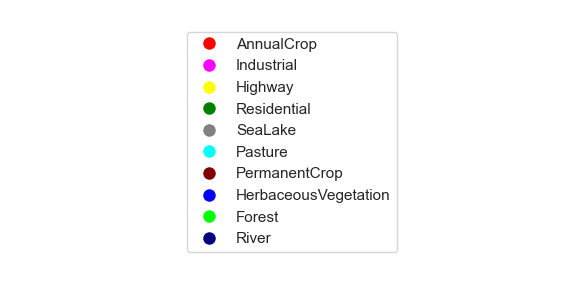

In [74]:
# Plot the legend
plt.figure(figsize=(6, 3))
plt.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.tight_layout()

# Show or save the legend
plt.show()

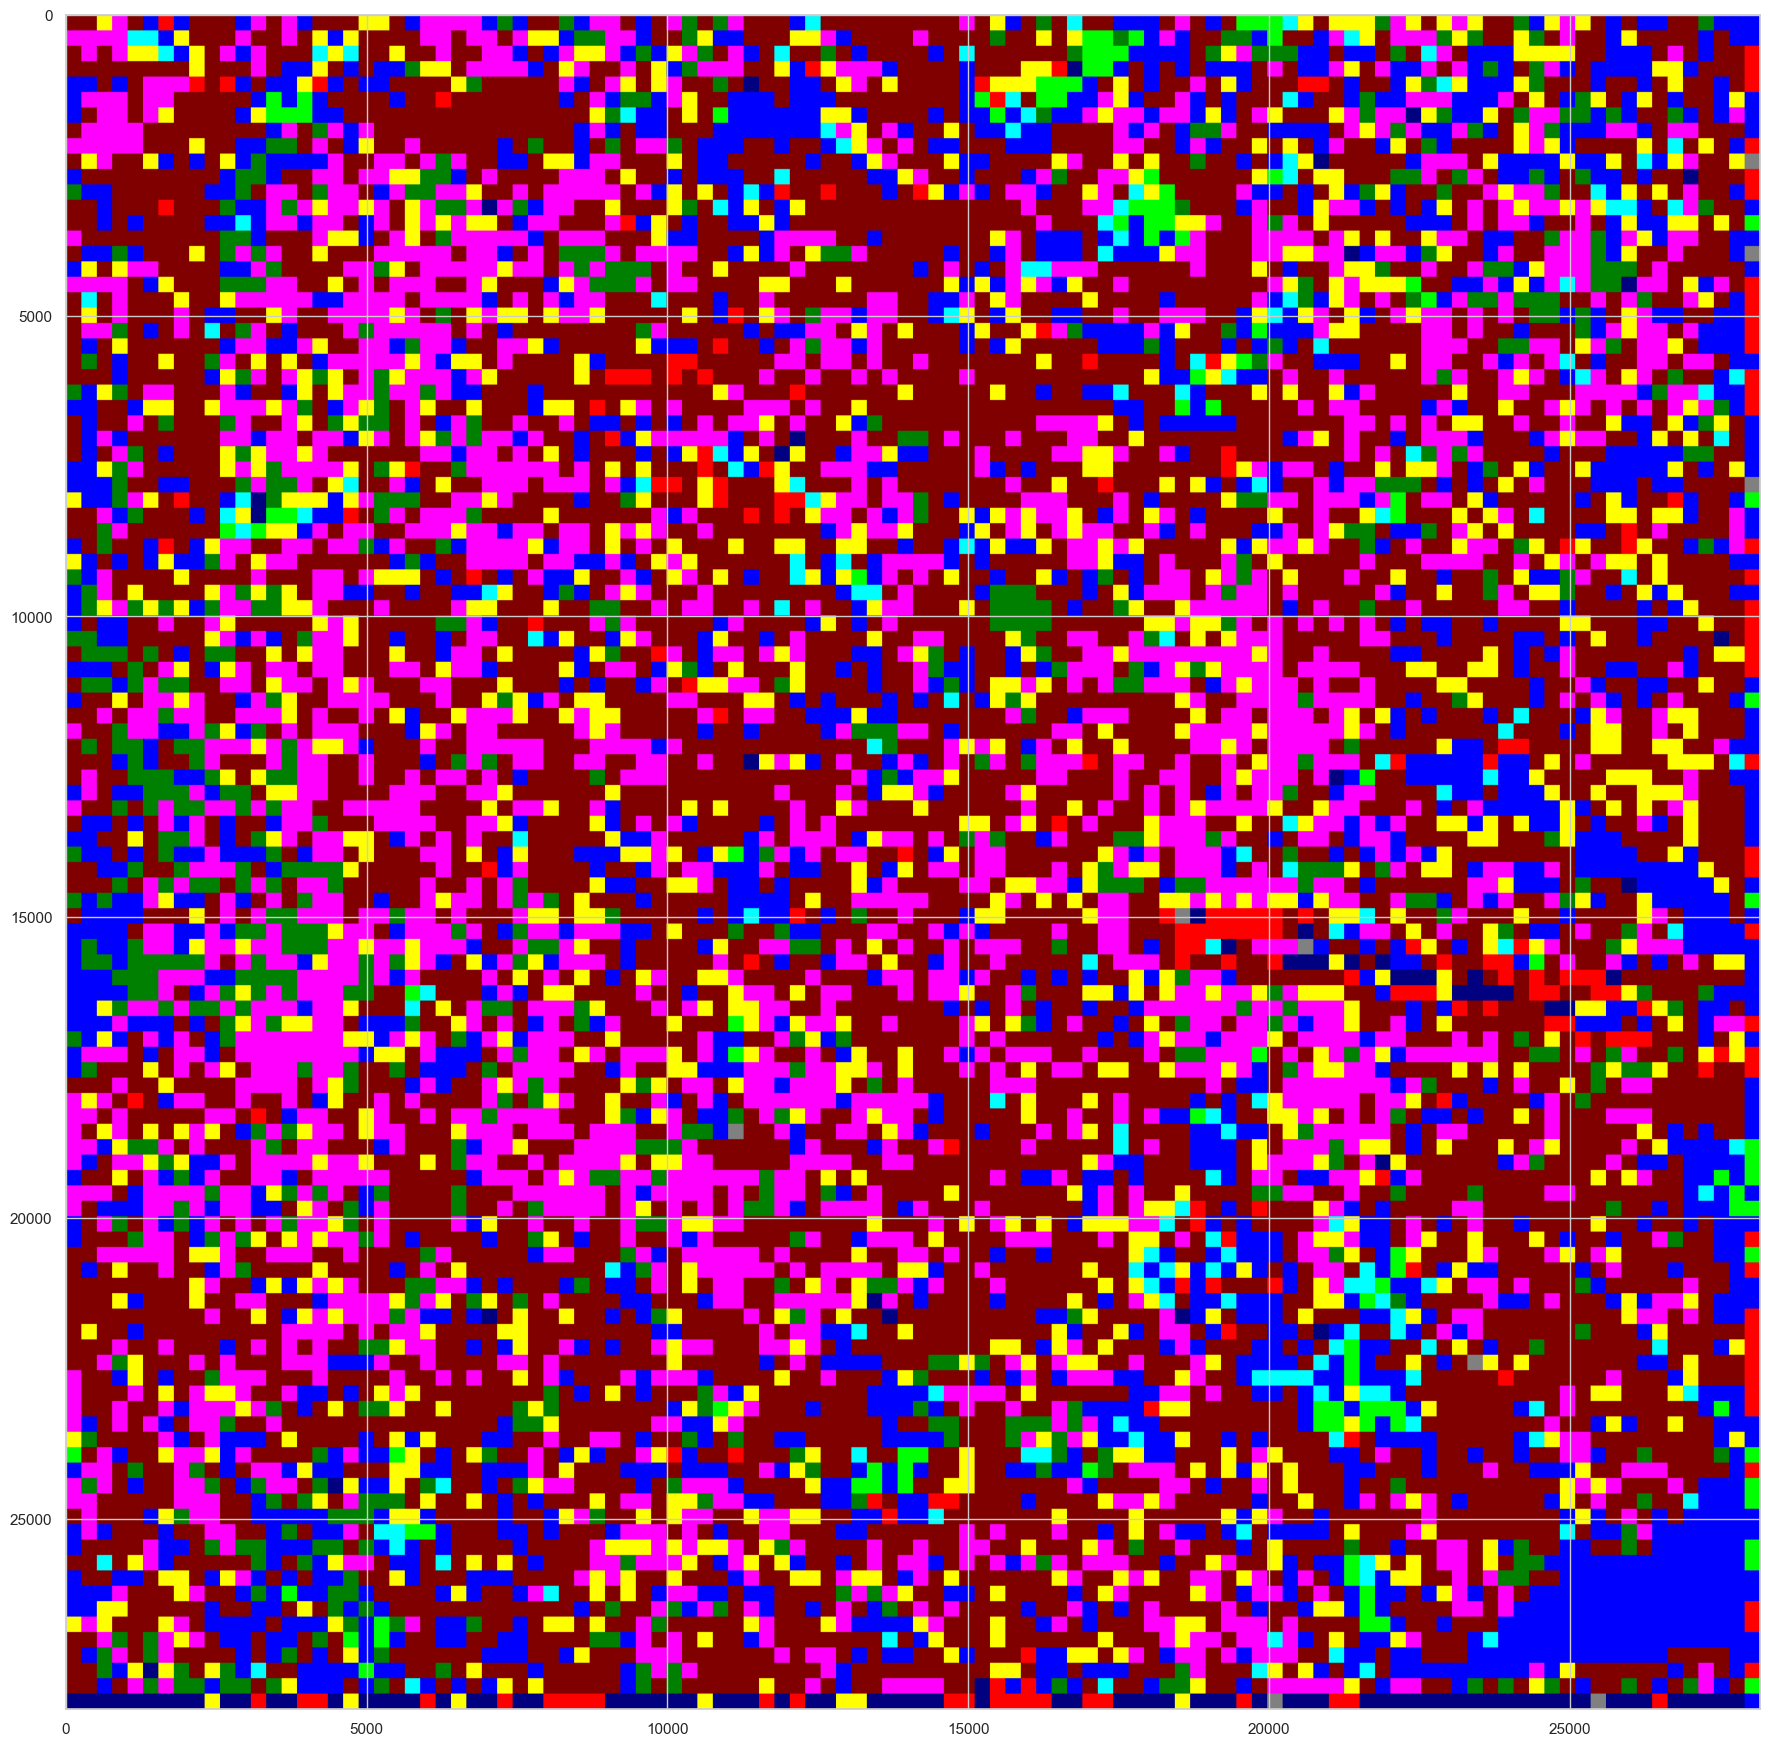

In [75]:
plt.figure(figsize=(22, 22))
plt.imshow(heatmap.read([1,2,3]).transpose(1, 2, 0))

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 64, 64, 8)         224       
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 32, 32, 8)         0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 32, 32, 16)        1168      
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 16, 16, 16)        0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 16, 16, 32)        4640      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 8, 8, 32)          0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 8, 8, 64)         

In [106]:
output_file3 = './dataset/NewclassificationMap.tif'

In [107]:
color_map = {
    0: 'red',       # AnnualCrop
    1: 'green',     # Forest
    2: 'blue',      # HerbaceousVegetation
    3: 'yellow',    # Highway
    4: 'magenta',   # Industrial
    5: 'cyan',      # Pasture
    6: 'maroon',    # PermanentCrop
    7: 'darkgreen', # Residential
    8: 'navy',      # River
}

In [108]:
with rasterio.open(output_file3, 'w', **profile) as dst:
    # Step 3-7: Make predictions and write predicted color to output2.tif
    for i, tile_image in enumerate(tile_images):
        with rasterio.open(tile_image) as src:
            # Step 3: Make prediction
            tile_data = src.read()
            tile_data = cv2.resize(tile_data.transpose(1, 2, 0), (64, 64))
            # Preprocess the image (if needed)
            # Perform any necessary preprocessing steps such as resizing, normalization, etc.
            
            prediction = model.predict(np.expand_dims(tile_data, axis=0))

            # Step 4: Assign a unique color to the tile based on the predicted class
            predicted_class_index = np.argmax(prediction)
            if predicted_class_index == 0:
                color_name = 'red'       # AnnualCrop
            elif predicted_class_index == 1:
                color_name = 'green'     # Forest
            elif predicted_class_index == 2:
                color_name = 'blue'      # HerbaceousVegetation
            elif predicted_class_index == 3:
                color_name = 'yellow'    # Highway
            elif predicted_class_index == 4:
                color_name = 'magenta'   # Industrial
            elif predicted_class_index == 5:
                color_name = 'cyan'      # Pasture
            elif predicted_class_index == 6:
                color_name = 'maroon'    # PermanentCrop
            elif predicted_class_index == 7:
                color_name = 'darkgreen' # Residential
            elif predicted_class_index == 8:
                color_name = 'navy'      # River
            else:
                color_name = 'gray'      # Gray for SeaLake

            # Step 5: Assign the color to the entire tile to represent the predicted class
            color_rgb = colors.to_rgb(color_name)
            color_tile_data = np.full(tile_data.shape, color_rgb, dtype=np.float32)

            # Step 6: Write the color to the appropriate location in the new TIF image
            window = Window(i % cols * width, i // cols * height, width, height)
            dst.write(color_tile_data.transpose(2, 0, 1), indexes=[1, 2, 3], window=window)